In [31]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import warnings

# Configuration for easier reading
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

# Style setting for plots
sns.set(style="whitegrid")

print("✅ Libraries imported and configurations set.")

✅ Libraries imported and configurations set.


In [32]:


# 1. Google Drive'ı Bağla
drive.mount('/content/drive')

# 2. Dosya Yolunu Tanımla
# Dosyanın Drive ana dizininde olduğunu varsayıyoruz.
file_path = "/content/drive/MyDrive/Media spending_2020.xlsx"

print("🚀 Veri Yükleniyor...")

# 3. Excel Dosyasını Oku
# Excel'deki sütun başlıklarını ve veri tiplerini otomatik tanıması için
try:
    df = pd.read_excel(file_path, engine='openpyxl')
    print(f"✅ Başarılı! Veri Seti Boyutu: {df.shape}")
    print("\n--- İlk 5 Satır ---")
    display(df.head())
except Exception as e:
    print(f"❌ Hata: Dosya okunamadı. Lütfen dosya yolunu kontrol et. Hata detayı: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Veri Yükleniyor...
✅ Başarılı! Veri Seti Boyutu: (28869, 23)

--- İlk 5 Satır ---


,Medium_Type,Main_Media_Name,Channel_Type,Product,Company,Sector,Subsector,Brand,Month,Year,Week,Spot_Type,Daypart,Campain_Type,Item_Count,Seconds,Stcm _Press,Page_Press,Frequency _Outdoor,Estimated_Cost,Actual_Cost (TL),GRP,"30""GRP"
0,Cinema,MARS MEDIA,Cinema,CAPPY DESTEK MEYVE SUYU,TCCC,NARTD,FRUIT JUICE,CAPPY,1,2020,01 (30/12/2019),Standard_Spot,Non_TV,MAINTHRUST,190,3610,0.00,0,0,0.00,16245.00,0.00,0.00
1,Cinema,MARS MEDIA,Cinema,COCA COLA LIME,TCCC,NARTD,CSD,COCA-COLA,1,2020,02 (06/01/2020),Standard_Spot,Non_TV,MAINTHRUST,389,5835,0.00,0,0,0.00,26257.50,0.00,0.00
2,Cinema,MARS MEDIA,Cinema,COCA COLA LIME,TCCC,NARTD,CSD,COCA-COLA,1,2020,03 (13/01/2020),Standard_Spot,Non_TV,MAINTHRUST,524,7860,0.00,0,0,0.00,35370.00,0.00,0.00
3,Cinema,MARS MEDIA,Cinema,COCA COLA LIME,TCCC,NARTD,CSD,COCA-COLA,1,2020,04 (20/01/2020),Standard_Spot,Non_TV,MAINTHRUST,440,6600,0.00,0,0,0.00,29700.00,0.00,0.00
4,Cinema,MARS MEDIA,Cinema,COCA COLA,TCCC,NARTD,CSD,COCA-COLA,1,2020,01 (30/12/2019),Standard_Spot,Non_TV,MAINTHRUST,2535,53240,0.00,0,0,0.00,239580.00,0.00,0.00


In [33]:
print(df.columns)

Index(['Medium_Type', 'Main_Media_Name', 'Channel_Type', ' Product',
       ' Company', 'Sector', ' Subsector', 'Brand', 'Month', 'Year', 'Week',
       'Spot_Type', 'Daypart', 'Campain_Type', 'Item_Count', 'Seconds',
       'Stcm _Press', 'Page_Press', 'Frequency _Outdoor', 'Estimated_Cost',
       'Actual_Cost (TL)', 'GRP ', '30"GRP '],
      dtype='object')


In [45]:
# ---------------------------------------------------------
# A. DATA PREPROCESSING & STANDARDIZATION (ROBUST VERSION)
# Objective: Auto-detect columns, clean types, create Date, and validate data.
# ---------------------------------------------------------


# 1. Sütun İsimlerindeki Boşlukları Temizle
df.columns = df.columns.str.strip()

# ---------------------------------------------------------
# ADIM 1: AKILLI SÜTUN TESPİTİ (DIAGNOSIS)
# "Cost" sütunu bazen boşluklu, bazen bitişik gelebilir. Hepsini tarayalım.
# ---------------------------------------------------------
possible_cost_cols = ['Actual_Cost (TL)', 'Actual_Cost(TL)', 'Actual_Cost', 'Cost', 'Cost (TL)']
found_cost_col = None

for col in possible_cost_cols:
    if col in df.columns:
        found_cost_col = col
        break

print(f"🕵️‍♂️ Tespit Edilen Cost Sütunu: '{found_cost_col}'")

# ---------------------------------------------------------
# ADIM 2: İSİM STANDARDİZASYONU (MAPPING)
# Bulduğumuz cost sütununu ve diğerlerini standart İngilizce isimlere çevirelim.
# ---------------------------------------------------------
rename_map = {
    'GRP': 'GRP',
    '30\"GRP': 'GRP_30',
    'Campain_Type': 'Campaign_Type',
    'Stcm _Press': 'Stcm_Press',
    'Frequency _Outdoor': 'Frequency_OOH',
    'Estimated_Cost': 'Estimated_Cost'
}

# Eğer Cost sütunu bulunduysa haritaya ekle
if found_cost_col:
    rename_map[found_cost_col] = 'Actual_Cost'

df.rename(columns=rename_map, inplace=True)

# ---------------------------------------------------------
# ADIM 3: GÜVENLİ TARİH OLUŞTURMA (TREATMENT)
# Year ve Month sütunlarını kullanarak Date sütunu oluşturuyoruz.
# ---------------------------------------------------------
print("⏳ Tarih sütunu (Date) oluşturuluyor...")

# Sayısal olmayan 'Year' ve 'Month' değerlerini temizle ve varsayılan değer ata
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(2020).astype(int)
df['Month'] = pd.to_numeric(df['Month'], errors='coerce').fillna(1).astype(int)

# Geçersiz ayları (1-12 arası olmayanları) temizle
df = df[(df['Month'] >= 1) & (df['Month'] <= 12)]

# Year ve Month kullanarak Date oluştur (ayın ilk günü)
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01', errors='coerce')

# 'Week' sütununu oluşturulan 'Date' sütunundan türet
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)

# Tarihi oluşmayan (NaT) satırları temizle
df = df.dropna(subset=['Date'])

# ---------------------------------------------------------
# ADIM 4: SAYISAL VERİLERİ GARANTİYE AL
# Cost, GRP vb. sütunlardaki metinleri veya boşlukları 0 yap.
# ---------------------------------------------------------
numeric_cols = ['Actual_Cost', 'Estimated_Cost', 'GRP', 'Seconds', 'Item_Count']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Veriyi tarihe göre sırala
df = df.sort_values('Date').reset_index(drop=True)

# ---------------------------------------------------------
# KONTROL NOKTASI (CHECKPOINT)
# ---------------------------------------------------------
print("-" * 40)
print("✅ VERİ ÖN İŞLEME TAMAMLANDI")
print("-" * 40)
print(f"📊 Toplam Satır Sayısı : {len(df)}")
print(f"💰 Toplam Harcama      : {df['Actual_Cost'].sum():,.0f} TL")
print(f"📅 Tarih Aralığı       : {df['Date'].min().date()} - {df['Date'].max().date()}")
print("-" * 40)

🕵️‍♂️ Tespit Edilen Cost Sütunu: 'Actual_Cost'
⏳ Tarih sütunu (Date) oluşturuluyor...
----------------------------------------
✅ VERİ ÖN İŞLEME TAMAMLANDI
----------------------------------------
📊 Toplam Satır Sayısı : 28869
💰 Toplam Harcama      : 162,373,316 TL
📅 Tarih Aralığı       : 2020-01-01 - 2020-12-01
----------------------------------------


In [46]:
# ---------------------------------------------------------
# B. METRIC CALCULATION
# Objective: Calculate efficiency metrics (CPP) & Tag Lockdown.
# ---------------------------------------------------------

# 1. CPP Hesapla (Actual_Cost / GRP)
# Sıfıra bölünme hatasını önlemek için np.where kullanıyoruz
if 'GRP' in df.columns and 'Actual_Cost' in df.columns:
    df['CPP'] = np.where(df['GRP'] > 0, df['Actual_Cost'] / df['GRP'], 0)
    print("✅ CPP (Cost Per Point) başarıyla hesaplandı.")

# 2. Pandemi Dönemi Etiketleme (Lockdown)
# Mart, Nisan, Mayıs aylarını (Q2) işaretliyoruz
if 'Date' in df.columns:
    df['Is_Lockdown'] = df['Date'].apply(
        lambda x: 1 if (x.year == 2020 and 3 <= x.month <= 5) else 0
    )
    print("✅ Pandemi Dönemi (Is_Lockdown) etiketlendi.")

display(df[['Date', 'Actual_Cost', 'GRP', 'CPP', 'Is_Lockdown']].head())

✅ CPP (Cost Per Point) başarıyla hesaplandı.
✅ Pandemi Dönemi (Is_Lockdown) etiketlendi.


,Date,Actual_Cost,GRP,CPP,Is_Lockdown
0,2020-01-01,16245.00,0.00,0.00,0
1,2020-01-01,6326.60,7.25,872.63,0
2,2020-01-01,31372.28,8.66,3622.66,0
3,2020-01-01,8921.00,6.40,1393.91,0
4,2020-01-01,17245.09,6.20,2781.47,0


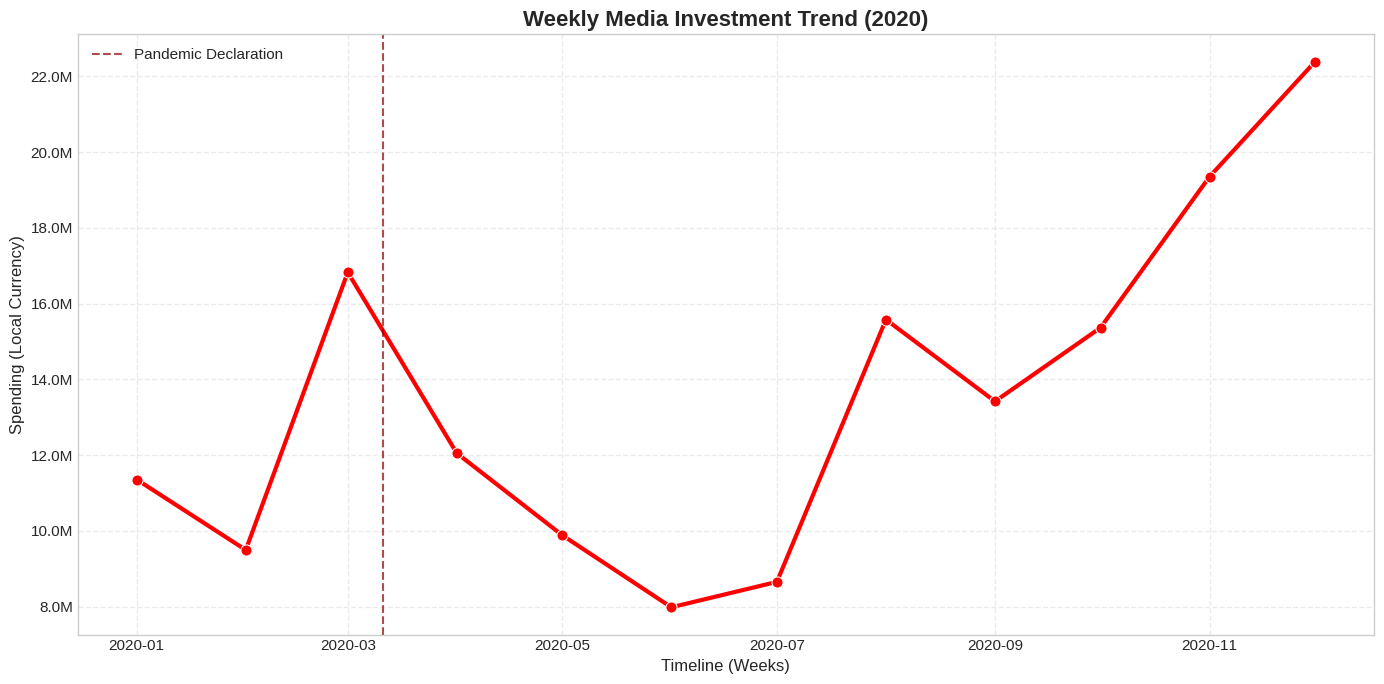

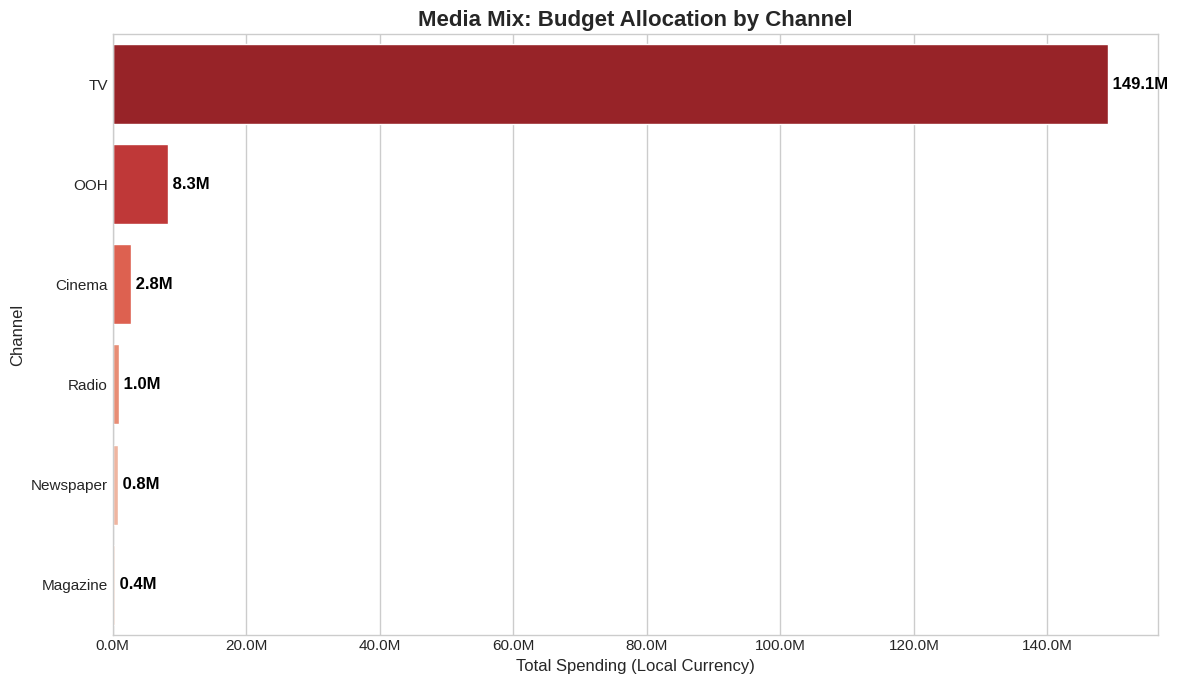

In [53]:
# ---------------------------------------------------------
# C. EXPLORATORY DATA ANALYSIS (EDA) - GÜNCEL
# Objective: Visualize Spending Trends & Media Mix with Professional Formatting.
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd

# Grafikler için temiz bir kopya alalım (Boş tarihleri ve maliyetleri at)
df_eda = df.dropna(subset=['Date', 'Actual_Cost']).copy()

# Tarihe göre sıralayalım ki çizgi grafik düzgün çıksın
df_eda = df_eda.sort_values('Date')

# --- Grafik 1: Haftalık Harcama Trendi (Time Series) ---
plt.figure(figsize=(14, 7))

# Haftalık toplam harcamayı hesapla
weekly_trend = df_eda.groupby('Date')['Actual_Cost'].sum().reset_index()

# Çizgi Grafiği Çiz
sns.lineplot(
    data=weekly_trend,
    x='Date',
    y='Actual_Cost',
    color='red', # Coca-Cola kırmızısı
    linewidth=3,
    marker='o',
    markersize=8
)

plt.title('Weekly Media Investment Trend (2020)', fontsize=16, fontweight='bold')
plt.ylabel('Spending (Local Currency)', fontsize=12)
plt.xlabel('Timeline (Weeks)', fontsize=12)

# Y Eksenini Milyon (M) Formatına Çevir
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Pandemi Başlangıcını İşaretle (Mart Ortası / ~11. Hafta)
pandemic_start = pd.to_datetime('2020-03-11')
plt.axvline(pandemic_start, color='darkred', linestyle='--', alpha=0.7, label='Pandemic Declaration') # Koyu kırmızı ton
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# --- Grafik 2: Mecra Dağılımı (Media Mix) ---
plt.figure(figsize=(12, 7))

# Mecra bazlı toplam harcamayı hesapla ve büyükten küçüğe sırala
media_mix = df_eda.groupby('Medium_Type')['Actual_Cost'].sum().reset_index().sort_values('Actual_Cost', ascending=False)

# Çubuk Grafiği Çiz
sns.barplot(
    data=media_mix,
    x='Actual_Cost',
    y='Medium_Type',
    palette='Reds_r' # Kırmızı tonları, en büyükten en küçüğe
)

plt.title('Media Mix: Budget Allocation by Channel', fontsize=16, fontweight='bold')
plt.xlabel('Total Spending (Local Currency)', fontsize=12)
plt.ylabel('Channel', fontsize=12)

# X Eksenini de Milyon (M) Formatına Çevir
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Barların ucuna net değerleri yaz
for index, row in enumerate(media_mix.itertuples()):
    # row.Actual_Cost değerini alıp pozisyonluyoruz
    plt.text(
        row.Actual_Cost,
        index,
        f" {row.Actual_Cost/1e6:.1f}M",
        va='center',
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()

INFO:prophet:n_changepoints greater than number of observations. Using 8.


🔮 Prophet Modeli 12 haftalık veri noktası ile eğitiliyor...


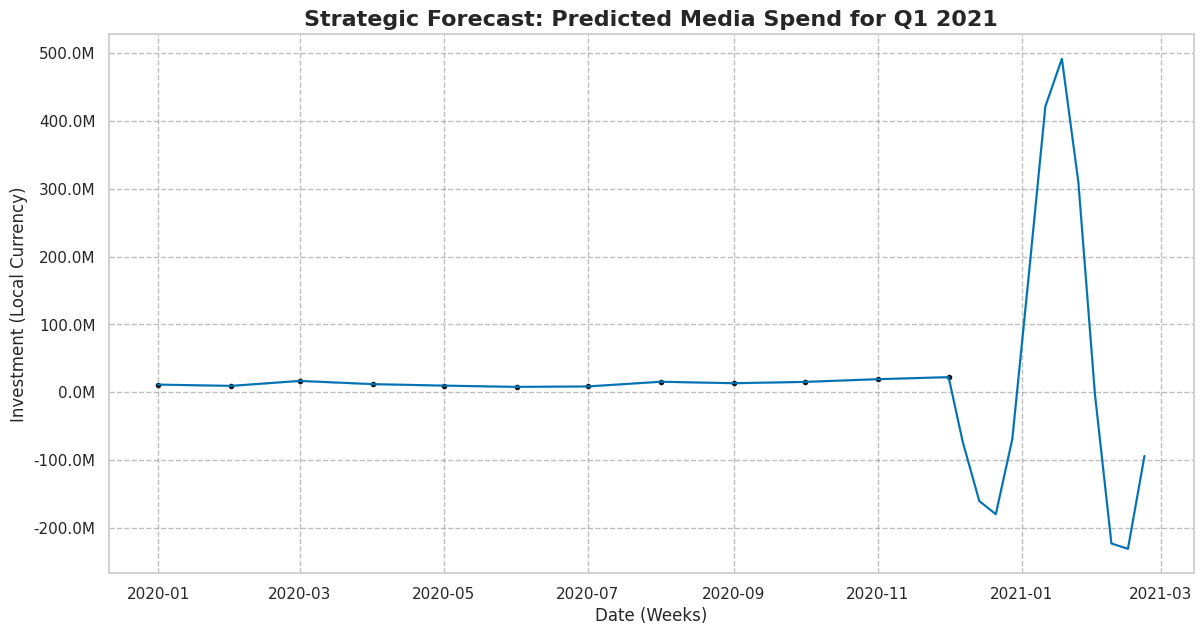

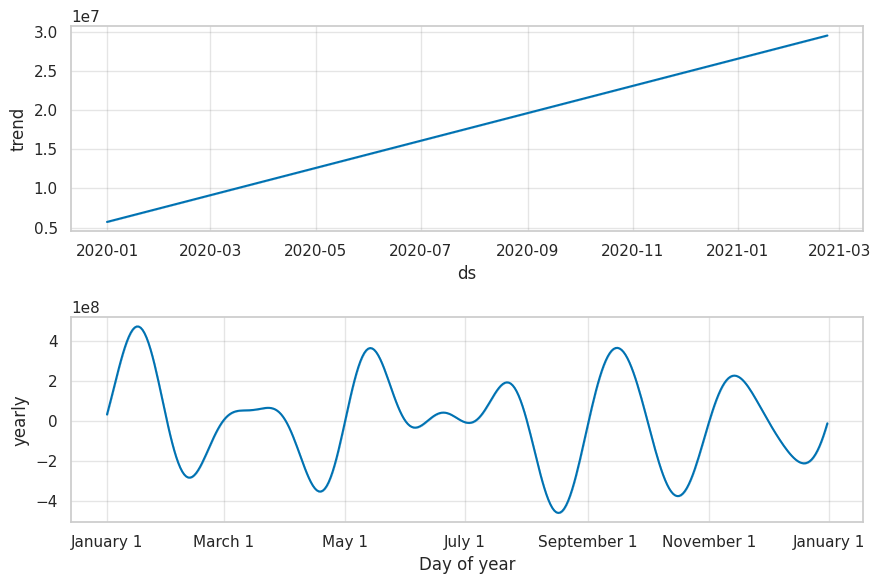


📅 Q1 2021 Tahmin Sonuçları (İlk 5 Hafta):


,ds,yhat,yhat_lower,yhat_upper
12,2020-12-07,-73425834.42,-73425834.44,-73425834.41
13,2020-12-14,-160398512.44,-160398512.63,-160398512.31
14,2020-12-21,-179855279.06,-179855279.54,-179855278.71
15,2020-12-28,-68751573.84,-68751574.65,-68751573.17
16,2021-01-04,173682262.12,173682260.92,173682263.21


In [48]:
# ---------------------------------------------------------
# D. ADVANCED ANALYTICS: FORECASTING (PROPHET) - GÜNCEL
# Objective: Forecast Q1 2021 Spending using Weekly Data.
# ---------------------------------------------------------
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. Veriyi Prophet Formatına Hazırla
# Temizlenmiş 'df' üzerinden sadece gerekli sütunları alıp grupluyoruz.
# (Eksik tarih veya maliyet varsa onları eliyoruz)
df_prophet = df.dropna(subset=['Date', 'Actual_Cost']).groupby('Date')['Actual_Cost'].sum().reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet kuralı: Sütun isimleri 'ds' ve 'y' olmalı

print(f"🔮 Prophet Modeli {len(df_prophet)} haftalık veri noktası ile eğitiliyor...")

# 2. Modeli Kur ve Eğit
# Verimiz haftalık olduğu için 'weekly_seasonality'yi kapatıyoruz.
# 'changepoint_prior_scale' parametresini 0.1 yaparak trend değişimlerine (pandemi şokları) karşı esnek bıraktık.
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

model.fit(df_prophet)

# 3. Gelecek Tahmini (Forecast)
# Gelecek 12 Hafta (Yaklaşık 3 Ay / Q1 2021)
# ÖNEMLİ: freq='W-MON' kullanıyoruz çünkü verimiz Pazartesi günlerine endeksli.
future = model.make_future_dataframe(periods=12, freq='W-MON')
forecast = model.predict(future)

# 4. Profesyonel Görselleştirme
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)

# Prophet'in çizimini eksenimize (ax) yönlendiriyoruz
model.plot(forecast, ax=ax)

plt.title('Strategic Forecast: Predicted Media Spend for Q1 2021', fontsize=16, fontweight='bold')
plt.xlabel('Date (Weeks)', fontsize=12)
plt.ylabel('Investment (Local Currency)', fontsize=12)

# Y Eksenini Milyon (M) Formatına Çevir (Okunabilirlik için)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

# 5. Trend ve Sezonsallık Bileşenleri
fig2 = model.plot_components(forecast)
plt.show()

# 6. Tahmin Değerlerini Raporla (Gelecek 5 Hafta)
print("\n📅 Q1 2021 Tahmin Sonuçları (İlk 5 Hafta):")
# Sadece geleceğe ait (son tarihten sonraki) tahminleri filtrele
last_history_date = df_prophet['ds'].max()
future_forecast = forecast[forecast['ds'] > last_history_date].head(5)

display(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

**NEW**

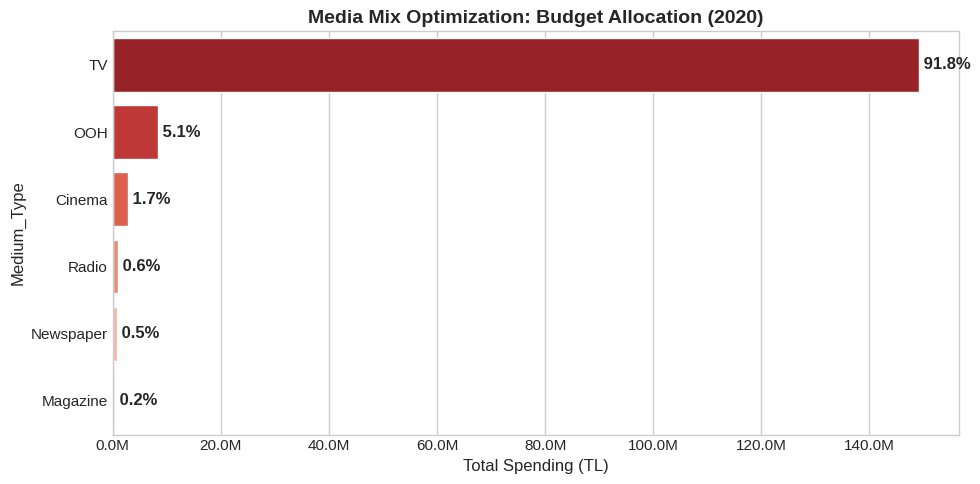

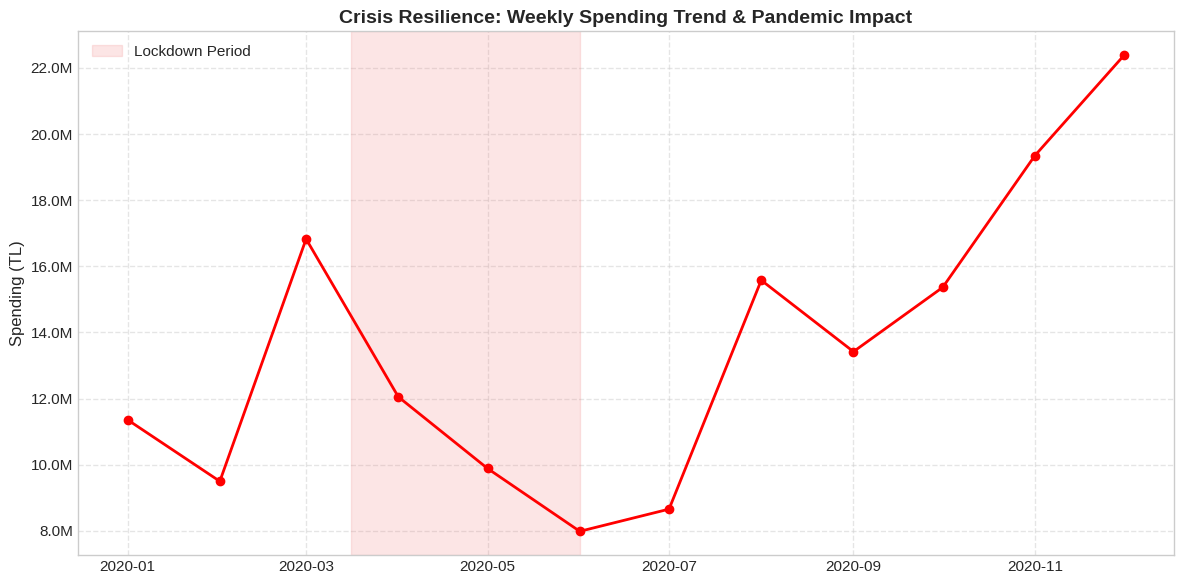

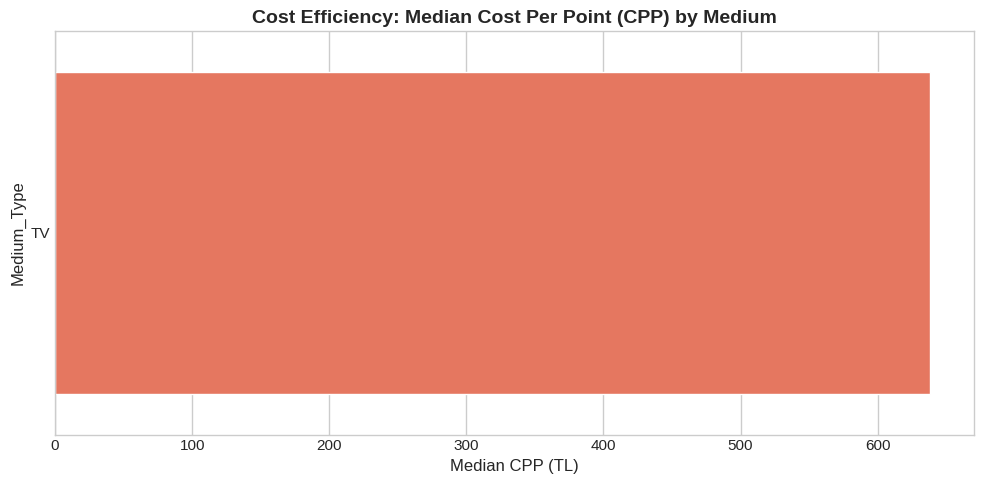

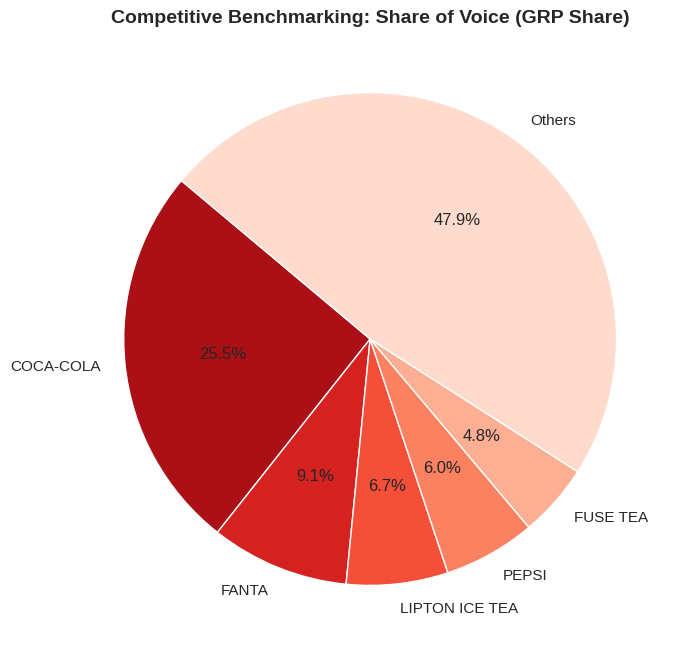

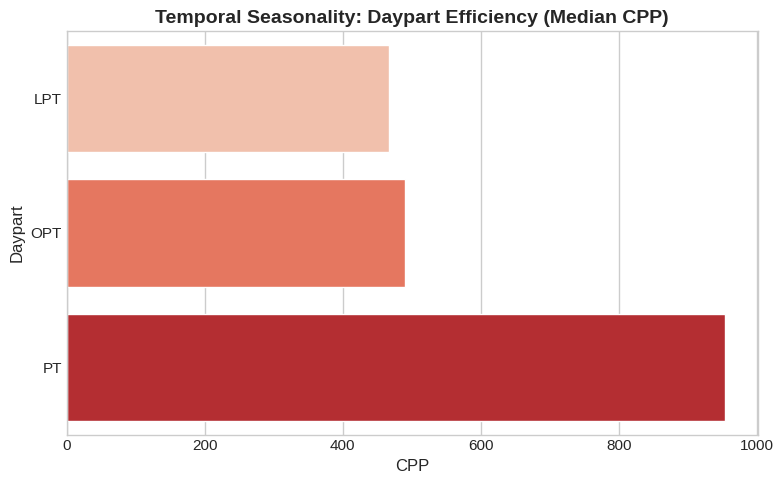

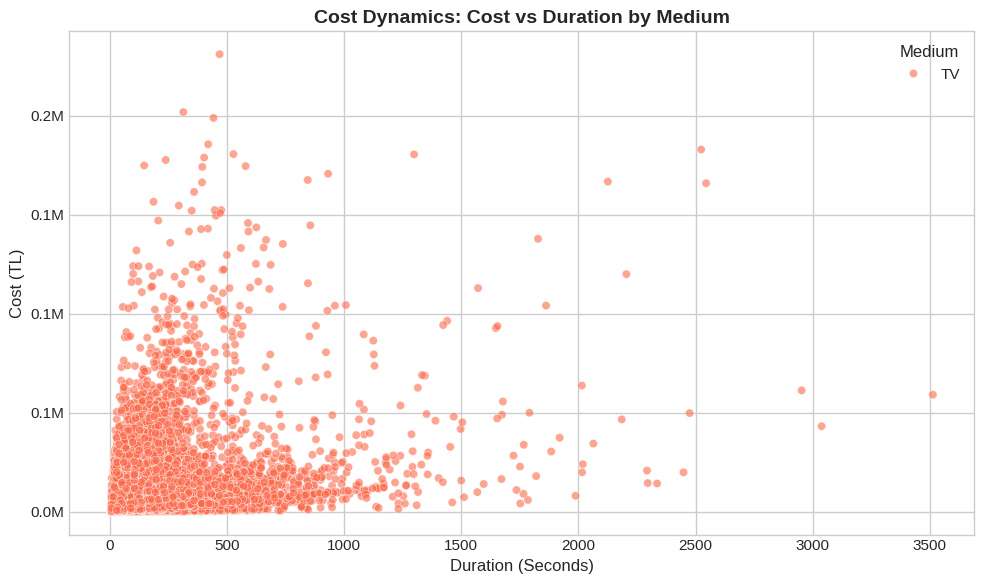

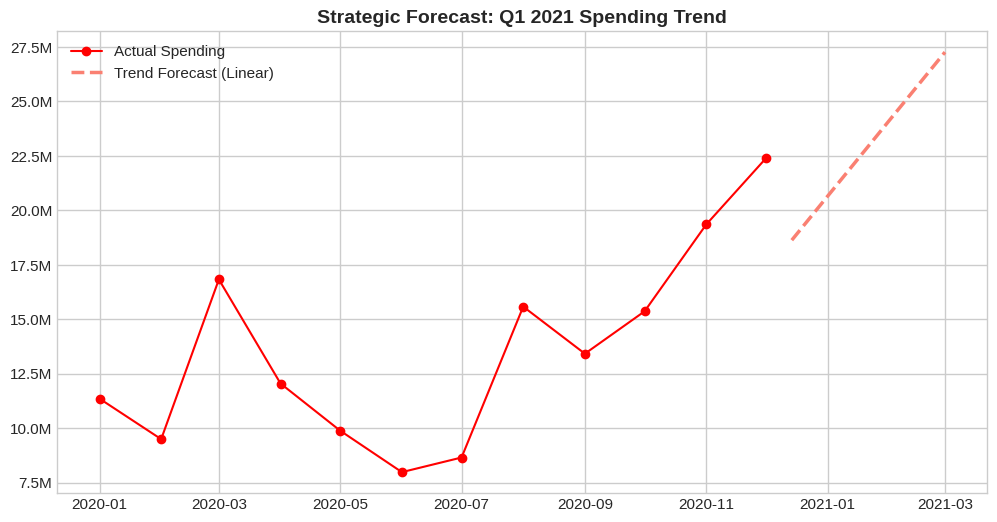

--- STRATEGIC INSIGHTS ---
1. Total Media Budget: 162.37 Million TL
2. Dominant Channel: TV (91.8% Share)
3. Most Efficient Channel (Lowest CPP): TV
4. Most Efficient Daypart: LPT
5. Market Leader (SOV): COCA-COLA (25.5% SOV)


In [55]:
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

# 1. DATA LOADING & PREPROCESSING - ALREADY HANDLED IN PREVIOUS CELLS
# ---------------------------------------------------------
# The DataFrame 'df' is already loaded and preprocessed from '/content/drive/MyDrive/Media spending_2020.xlsx'
# by cells su5NO2r8PuUT and RRqRlH7mWvb8.
# Feature engineering (CPP, Is_Lockdown) is done in cell fIUVeX1QUm29.

# Using the existing 'df' DataFrame for analyses.

# 2. FEATURE ENGINEERING (Adding CPS metric)
# ---------------------------------------------------------
# CPP (Cost Per Point) and Is_Lockdown are already calculated in previous cells.

# CPS (Cost Per Second) - for inflation/cost dynamics
if 'Seconds' in df.columns and 'Actual_Cost' in df.columns:
    df['CPS'] = np.where(df['Seconds'] > 0, df['Actual_Cost'] / df['Seconds'], np.nan)
else:
    print("⚠️ 'Seconds' or 'Actual_Cost' column not found, 'CPS' cannot be calculated.")


# 3. ANALYSES & VISUALIZATIONS
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# A. Media Mix Optimization
media_mix = df.groupby('Medium_Type')['Actual_Cost'].sum().reset_index().sort_values('Actual_Cost', ascending=False)
total_budget = media_mix['Actual_Cost'].sum()
media_mix['Share'] = media_mix['Actual_Cost'] / total_budget * 100

plt.figure(figsize=(10, 5))
sns.barplot(data=media_mix, x='Actual_Cost', y='Medium_Type', palette='Reds_r') # Kırmızı tonları
plt.title('Media Mix Optimization: Budget Allocation (2020)', fontsize=14, fontweight='bold')
plt.xlabel('Total Spending (TL)')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
for index, row in enumerate(media_mix.itertuples()):
    plt.text(row.Actual_Cost, index, f" {row.Share:.1f}%", va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# B. Crisis Resilience Strategy
weekly_spend = df.groupby('Date')['Actual_Cost'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(weekly_spend['Date'], weekly_spend['Actual_Cost'], color='red', linewidth=2, marker='o') # Kırmızı çizgi
plt.axvspan(pd.to_datetime('2020-03-16'), pd.to_datetime('2020-06-01'), color='lightcoral', alpha=0.2, label='Lockdown Period') # Açık kırmızı ton
plt.title('Crisis Resilience: Weekly Spending Trend & Pandemic Impact', fontsize=14, fontweight='bold')
plt.ylabel('Spending (TL)')
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# C. Cost Efficiency Analysis (CPP)
df_measured = df[df['GRP'] > 0]
cpp_analysis = df_measured.groupby('Medium_Type')['CPP'].median().reset_index().sort_values('CPP')

plt.figure(figsize=(10, 5))
sns.barplot(data=cpp_analysis, x='CPP', y='Medium_Type', palette='Reds') # Kırmızı tonları (tersi değil, daha düşük CPP daha koyu)
plt.title('Cost Efficiency: Median Cost Per Point (CPP) by Medium', fontsize=14, fontweight='bold')
plt.xlabel('Median CPP (TL)')
plt.tight_layout()
plt.show()

# D. Competitive Benchmarking (SOV)
brand_sov = df.groupby('Brand')['GRP'].sum().reset_index().sort_values('GRP', ascending=False)
top_5_brands = brand_sov.head(5)
others_grp = brand_sov.iloc[5:]['GRP'].sum()
top_5_brands = pd.concat([top_5_brands, pd.DataFrame({'Brand': ['Others'], 'GRP': [others_grp]})])

plt.figure(figsize=(8, 8))
# Kırmızı tonlarında bir palet oluştur
red_palette = sns.color_palette('Reds_r', len(top_5_brands)) # Ters kırmızı palet, en büyüğe en koyu
plt.pie(top_5_brands['GRP'], labels=top_5_brands['Brand'], autopct='%1.1f%%', startangle=140, colors=red_palette)
plt.title('Competitive Benchmarking: Share of Voice (GRP Share)', fontsize=14, fontweight='bold')
plt.show()

# E. Temporal Seasonality (Dayparting)
df_daypart = df[df['Medium_Type'].isin(['TV', 'Radio']) & (df['GRP'] > 0)]
if not df_daypart.empty:
    daypart_eff = df_daypart.groupby('Daypart')['CPP'].median().reset_index().sort_values('CPP')
    plt.figure(figsize=(8, 5))
    sns.barplot(data=daypart_eff, x='CPP', y='Daypart', palette='Reds') # Kırmızı tonları
    plt.title('Temporal Seasonality: Daypart Efficiency (Median CPP)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# F. Cost Dynamics (CPS)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_measured, x='Seconds', y='Actual_Cost', hue='Medium_Type', palette='Reds', alpha=0.6) # Hue farklı mecra tipleri için kalacak, palette Reds
plt.title('Cost Dynamics: Cost vs Duration by Medium', fontsize=14, fontweight='bold')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Cost (TL)')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.legend(title='Medium')
plt.tight_layout()
plt.show()

# G. Time Series Forecasting (Linear Regression Proxy)
# Prepare Data
df_ts = weekly_spend.copy()
df_ts['Time_Index'] = np.arange(len(df_ts))

# Fit Model
model = LinearRegression()
model.fit(df_ts[['Time_Index']], df_ts['Actual_Cost'])

# Forecast Next 12 Weeks
future_indices = np.arange(len(df_ts), len(df_ts) + 12).reshape(-1, 1)
future_dates = pd.date_range(start=df_ts['Date'].max(), periods=13, freq='W-MON')[1:]
forecast_values = model.predict(future_indices)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_ts['Date'], df_ts['Actual_Cost'], label='Actual Spending', marker='o', color='red') # Kırmızı çizgi
plt.plot(future_dates, forecast_values, label='Trend Forecast (Linear)', linestyle='--', color='salmon', linewidth=2.5) # Daha açık kırmızı ton
plt.title('Strategic Forecast: Q1 2021 Spending Trend', fontsize=14, fontweight='bold')
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.show()

print("--- STRATEGIC INSIGHTS ---")
print(f"1. Total Media Budget: {total_budget/1e6:.2f} Million TL")
print(f"2. Dominant Channel: {media_mix.iloc[0]['Medium_Type']} ({media_mix.iloc[0]['Share']:.1f}% Share)")
print(f"3. Most Efficient Channel (Lowest CPP): {cpp_analysis.iloc[0]['Medium_Type']}")
if not df_daypart.empty:
    print(f"4. Most Efficient Daypart: {daypart_eff.iloc[0]['Daypart']}")
print(f"5. Market Leader (SOV): {brand_sov.iloc[0]['Brand']} ({brand_sov.iloc[0]['GRP']/brand_sov['GRP'].sum()*100:.1f}% SOV)")

🏆 Top 10 Competitors Identified: ['COCA-COLA', 'FANTA', 'FUSE TEA', 'PEPSI', 'ULUDAG MADEN SUYU', 'LIPTON ICE TEA', 'SPRITE', 'ULUDAG GAZOZ', 'RED BULL', 'DAMLA SU']


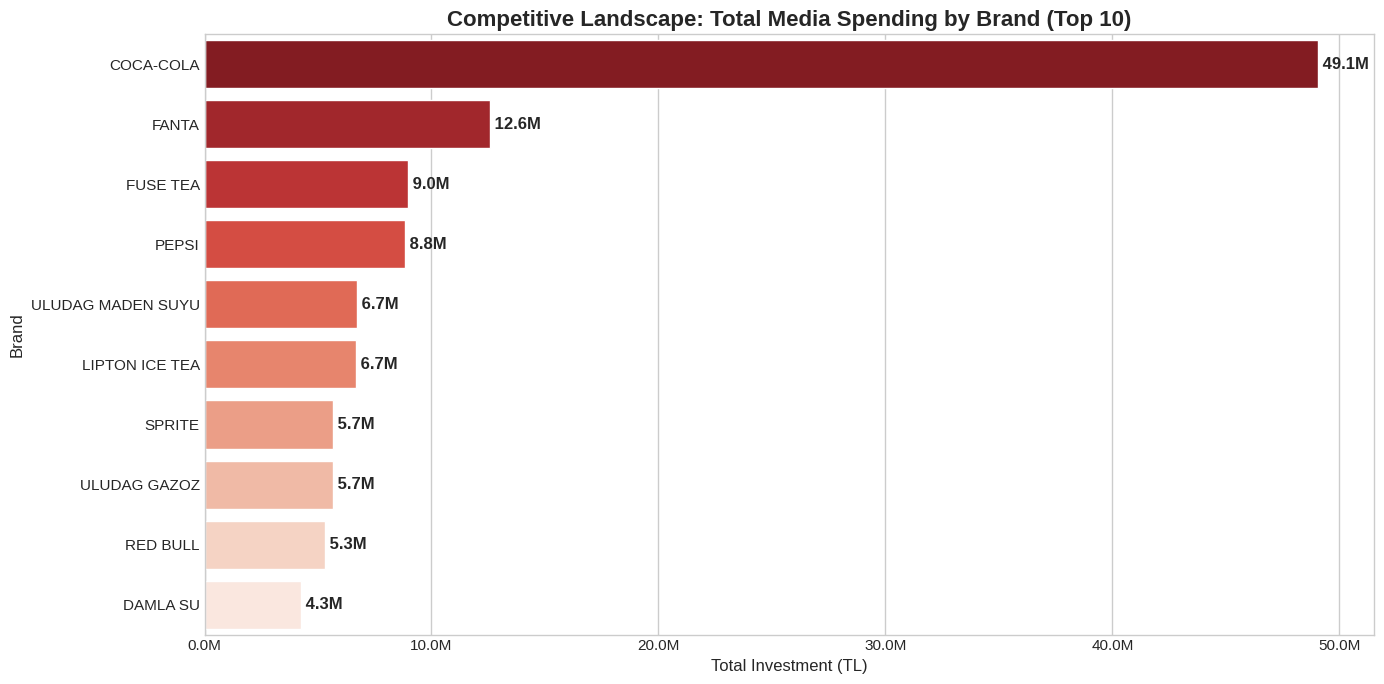

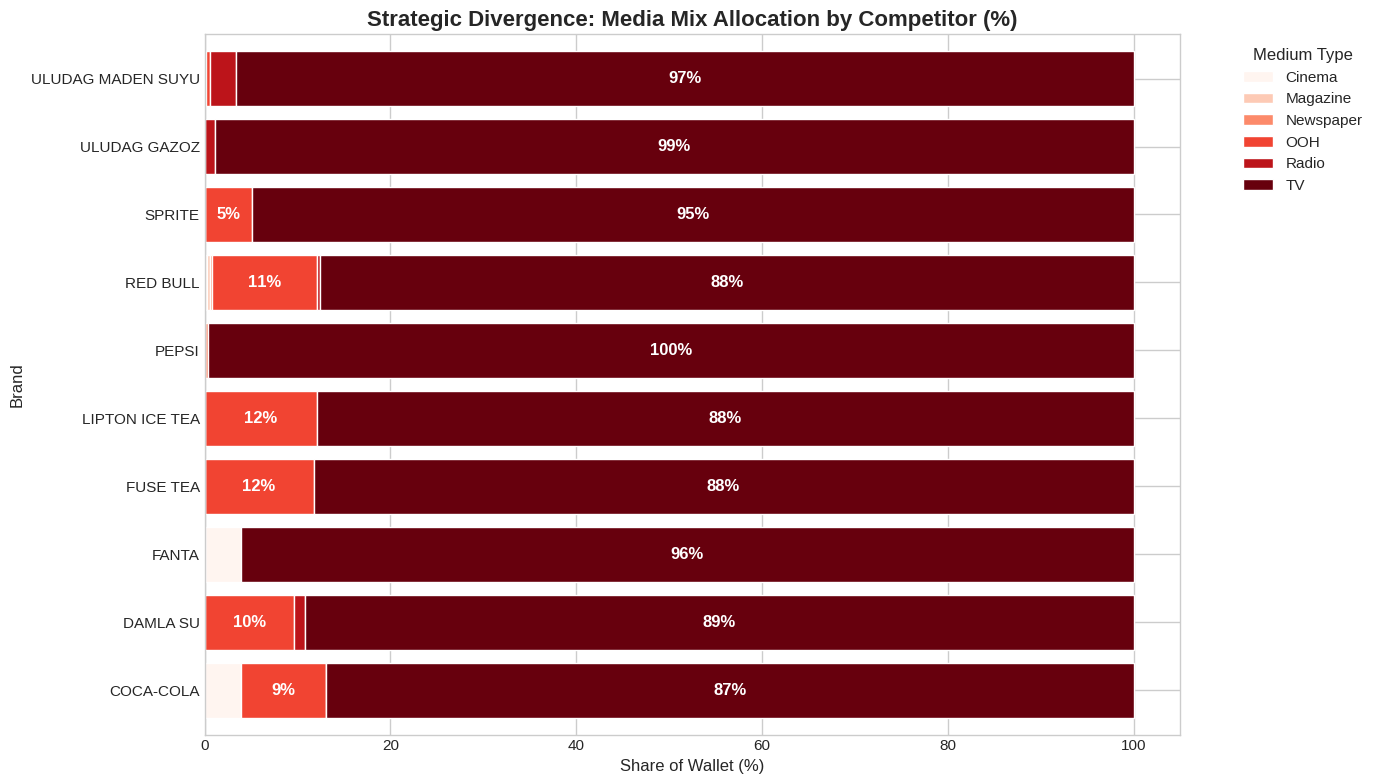

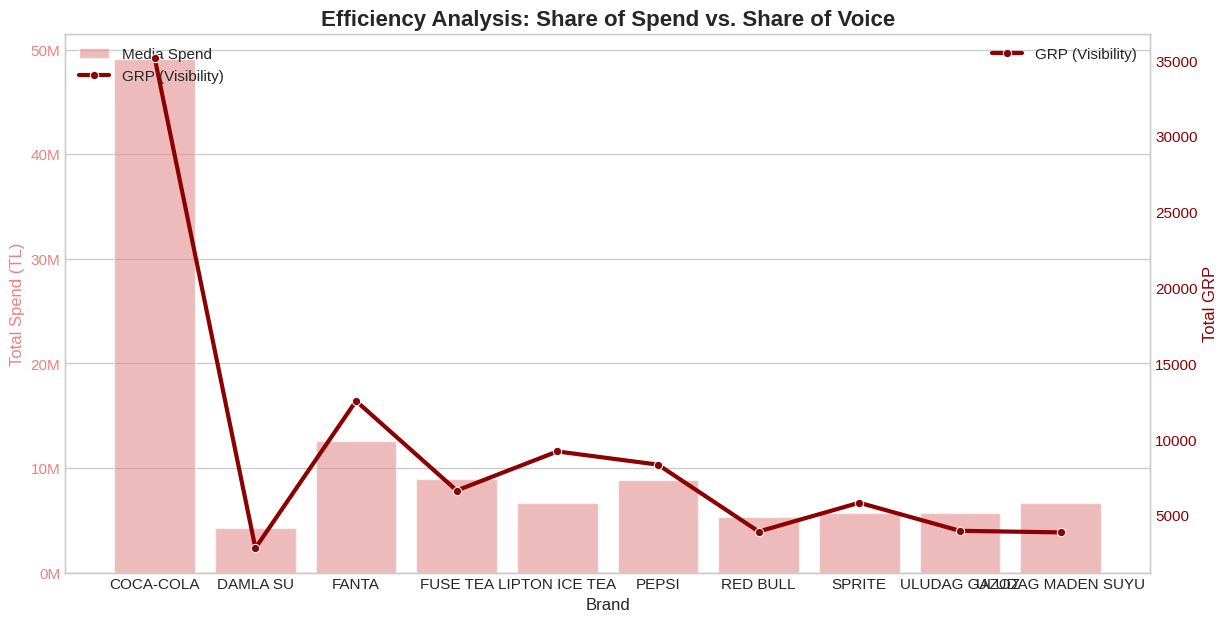

In [57]:
# ---------------------------------------------------------
# E. COMPETITOR ANALYSIS: SHARE OF SPEND & MEDIA STRATEGY
# Objective: Analyze Coca-Cola vs. Competitors in the Turkish Market.
# ---------------------------------------------------------


# 1. DATA PREPARATION FOR COMPETITORS
# ---------------------------------------------------------
# Ensure we are using the cleaned dataframe 'df' from previous steps.
# If starting fresh, uncomment the loading steps below:
# df = pd.read_csv('Media spending_2020.xlsx - 2020.csv')
# ... (Apply standard cleaning steps here if needed) ...

# Filter: Focus on the Top 10 Brands by Spending to keep charts readable
# (The dataset contains many small brands, we want the main players)
top_brands_df = df.groupby('Brand')['Actual_Cost'].sum().reset_index().sort_values('Actual_Cost', ascending=False).head(10)
top_brands_list = top_brands_df['Brand'].tolist()

# Filter the main dataframe for these top 10 brands
df_competitors = df[df['Brand'].isin(top_brands_list)].copy()

print(f"🏆 Top 10 Competitors Identified: {top_brands_list}")

# 2. VISUALIZATION 1: SHARE OF SPEND (TOTAL BUDGET COMPARISON)
# ---------------------------------------------------------
plt.figure(figsize=(14, 7))
sns.barplot(
    data=top_brands_df,
    x='Actual_Cost',
    y='Brand',
    palette='Reds_r' # Kırmızı tonları
)

plt.title('Competitive Landscape: Total Media Spending by Brand (Top 10)', fontsize=16, fontweight='bold')
plt.xlabel('Total Investment (TL)', fontsize=12)
plt.ylabel('Brand', fontsize=12)

# Format X-axis to Millions
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Add Labels
for index, row in enumerate(top_brands_df.itertuples()):
    plt.text(row.Actual_Cost, index, f" {row.Actual_Cost/1e6:.1f}M", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. VISUALIZATION 2: MEDIA MIX STRATEGY BY COMPETITOR
# ---------------------------------------------------------
# Pivot data to get Brands as Rows and Media Types as Columns
brand_media_mix = df_competitors.groupby(['Brand', 'Medium_Type'])['Actual_Cost'].sum().unstack().fillna(0)

# Calculate Percentage (100% Stacked Bar) to compare strategies, not just volume
brand_media_mix_pct = brand_media_mix.div(brand_media_mix.sum(axis=1), axis=0) * 100

# Plotting
ax = brand_media_mix_pct.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    colormap='Reds', # Kırmızı renk haritası
    width=0.8
)

plt.title('Strategic Divergence: Media Mix Allocation by Competitor (%)', fontsize=16, fontweight='bold')
plt.xlabel('Share of Wallet (%)', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.legend(title='Medium Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add Percentage Labels inside bars
for c in ax.containers:
    # Filter out small segments to avoid clutter
    labels = [f'{w:.0f}%' if w > 5 else '' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# 4. VISUALIZATION 3: SHARE OF VOICE (GRP) VS SHARE OF SPEND
# ---------------------------------------------------------
# Compare "Money Spent" vs "Visibility Gained"
# High Spend but Low GRP = Low Efficiency
comparison = df_competitors.groupby('Brand')[['Actual_Cost', 'GRP']].sum().reset_index()

# Normalize for visualization (Scale 0-1) or just use dual axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar Chart for Spend
sns.barplot(data=comparison, x='Brand', y='Actual_Cost', alpha=0.6, color='lightcoral', ax=ax1, label='Media Spend') # Açık kırmızı ton
ax1.set_ylabel('Total Spend (TL)', color='lightcoral', fontsize=12) # Açık kırmızı ton
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M'))
ax1.tick_params(axis='y', labelcolor='lightcoral')

# Line Chart for GRP
ax2 = ax1.twinx()
sns.lineplot(data=comparison, x='Brand', y='GRP', color='darkred', marker='o', linewidth=3, ax=ax2, label='GRP (Visibility)') # Koyu kırmızı ton
ax2.set_ylabel('Total GRP', color='darkred', fontsize=12) # Koyu kırmızı ton
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('Efficiency Analysis: Share of Spend vs. Share of Voice', fontsize=16, fontweight='bold')
plt.grid(False) # Turn off grid for cleaner look

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

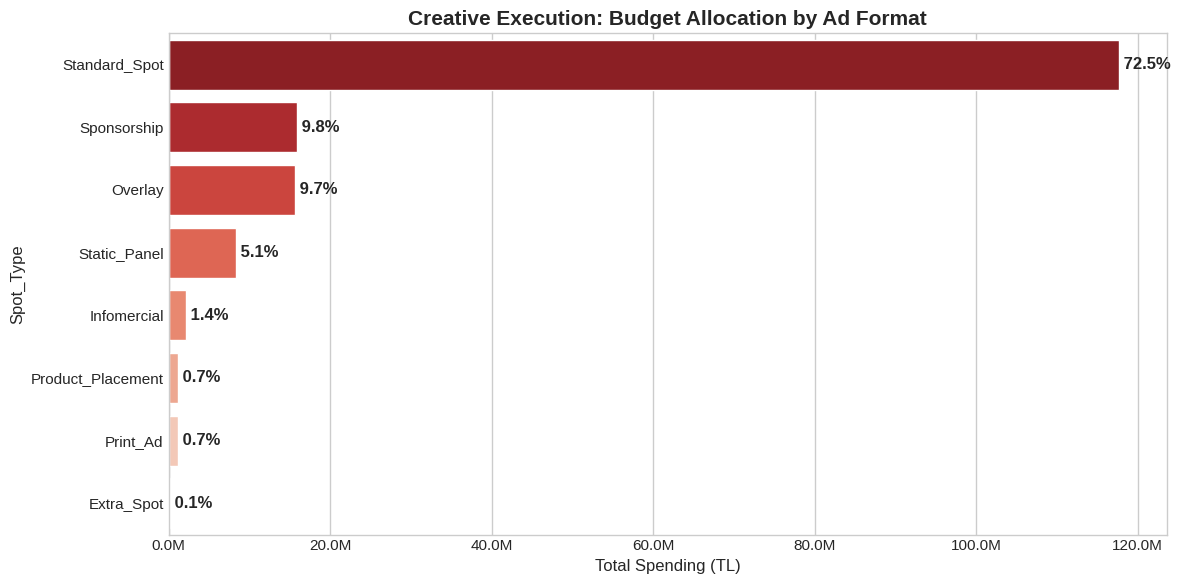

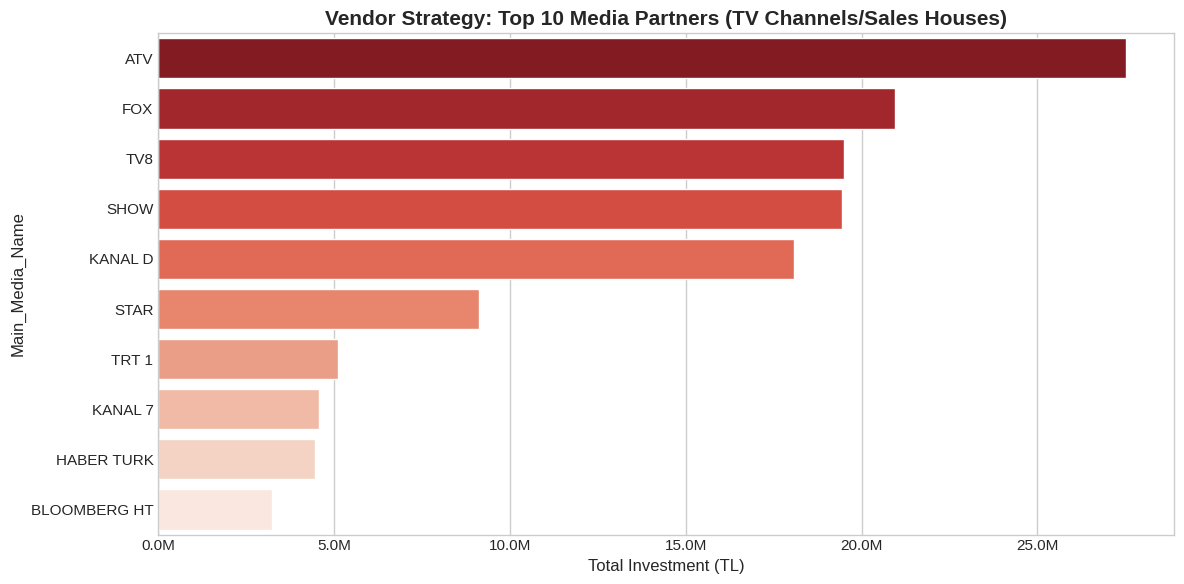

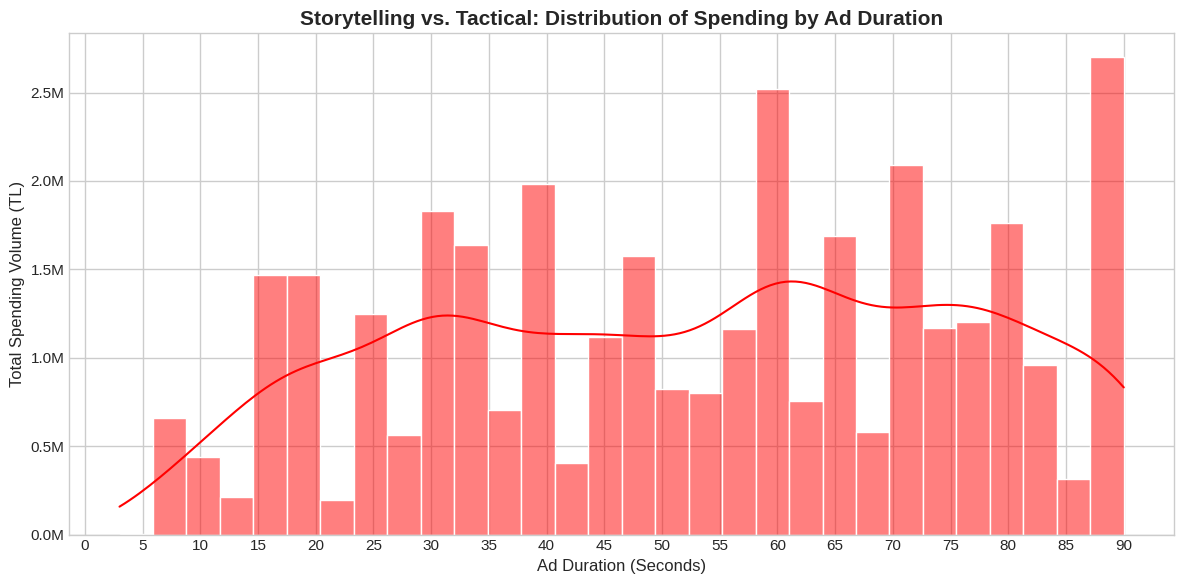

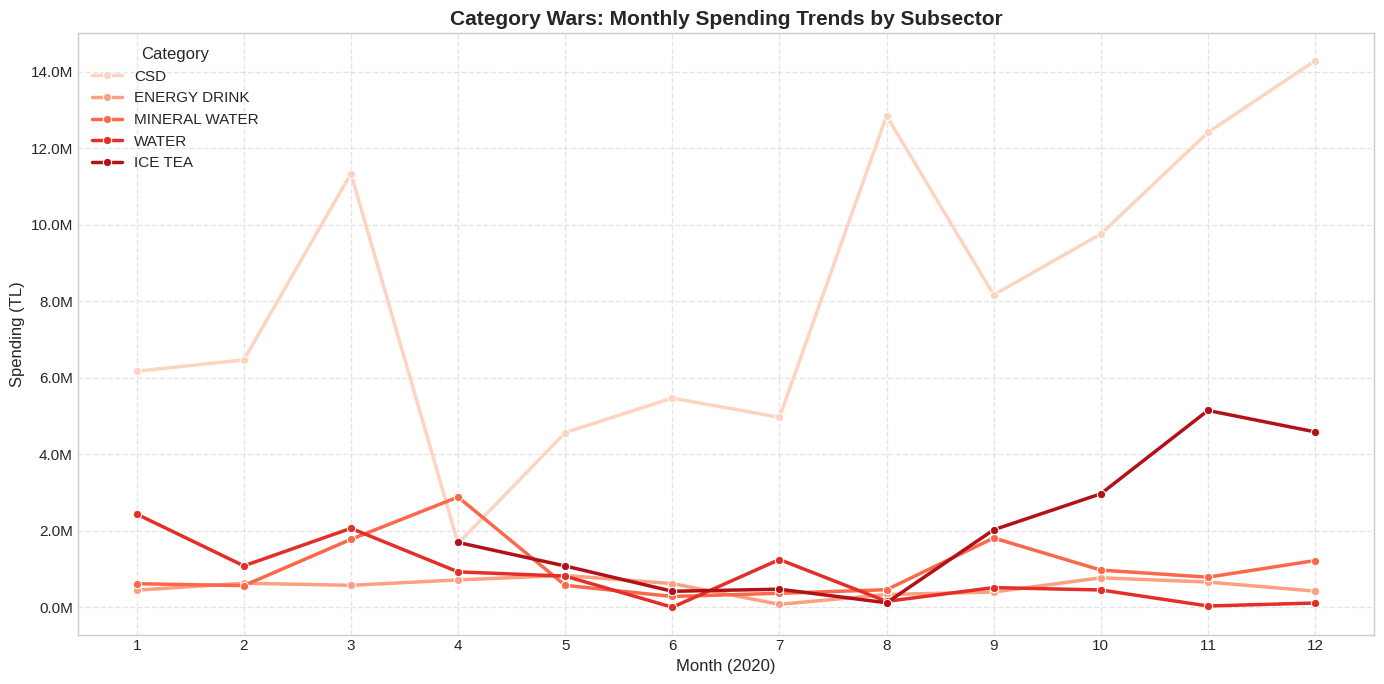

In [59]:
# ---------------------------------------------------------
# F. DEEP DIVE ANALYTICS: FORMAT, VENDOR, DURATION & SECTOR
# Objective: Uncover hidden tactical strategies.
# ---------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# (Ön Hazırlık: df'in yüklü ve temizlenmiş olduğu varsayılıyor)
# Eğer df yoksa önceki temizlik kodlarını çalıştırdığından emin ol.

plt.style.use('seaborn-v0_8-whitegrid')

# 1. FORMAT STRATEJİSİ (SPOT TYPE ANALYSIS)
# ---------------------------------------------------------
# Markalar standart reklam harici neleri kullanıyor?
spot_mix = df.groupby('Spot_Type')['Actual_Cost'].sum().reset_index().sort_values('Actual_Cost', ascending=False)
total_spot_budget = spot_mix['Actual_Cost'].sum()
spot_mix['Share'] = spot_mix['Actual_Cost'] / total_spot_budget * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=spot_mix.head(8), x='Actual_Cost', y='Spot_Type', palette='Reds_r') # Kırmızı tonları
plt.title('Creative Execution: Budget Allocation by Ad Format', fontsize=15, fontweight='bold')
plt.xlabel('Total Spending (TL)')

# X Eksenini Milyon (M) Formatına Çevir
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Yüzdeleri Yaz
for index, row in enumerate(spot_mix.head(8).itertuples()):
    plt.text(row.Actual_Cost, index, f" {row.Share:.1f}%", va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. TEDARİKÇİ KONSANTRASYONU (VENDOR STRATEGY)
# ---------------------------------------------------------
# Parayı hangi kanallar alıyor? (Pareto İlkesi: %80 harcama hangi %20 kanala gidiyor?)
vendor_mix = df.groupby('Main_Media_Name')['Actual_Cost'].sum().reset_index().sort_values('Actual_Cost', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=vendor_mix, x='Actual_Cost', y='Main_Media_Name', palette='Reds_r') # Kırmızı tonları
plt.title('Vendor Strategy: Top 10 Media Partners (TV Channels/Sales Houses)', fontsize=15, fontweight='bold')
plt.xlabel('Total Investment (TL)')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.tight_layout()
plt.show()

# 3. SÜRE STRATEJİSİ (DURATION ANALYSIS)
# ---------------------------------------------------------
# Histogram ile reklam sürelerinin dağılımı
# 0-60 saniye arasına odaklanalım
df_duration = df[(df['Seconds'] > 0) & (df['Seconds'] <= 90)]

plt.figure(figsize=(12, 6))
sns.histplot(data=df_duration, x='Seconds', bins=30, weights='Actual_Cost', color='red', kde=True) # Kırmızı renk
plt.title('Storytelling vs. Tactical: Distribution of Spending by Ad Duration', fontsize=15, fontweight='bold')
plt.xlabel('Ad Duration (Seconds)')
plt.ylabel('Total Spending Volume (TL)')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.xticks(range(0, 91, 5)) # 5 saniyede bir işaret koy
plt.tight_layout()
plt.show()

# 4. KATEGORİ SAVAŞLARI (SUBSECTOR DYNAMICS)
# ---------------------------------------------------------
# Alt sektörlerin (Gazlı, Su, Meyve Suyu) aylık harcama trendi
# Sütun adı bazen boşluklu olabilir, kontrol edelim
subsector_col = ' Subsector' if ' Subsector' in df.columns else 'Subsector'

# Ana kategorileri al (Çok küçükleri ele)
top_sectors = df[subsector_col].value_counts().head(5).index
df_sector = df[df[subsector_col].isin(top_sectors)]

sector_trend = df_sector.groupby(['Month', subsector_col])['Actual_Cost'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=sector_trend, x='Month', y='Actual_Cost', hue=subsector_col, palette='Reds', linewidth=2.5, marker='o') # Kırmızı tonlarında palet
plt.title('Category Wars: Monthly Spending Trends by Subsector', fontsize=15, fontweight='bold')
plt.ylabel('Spending (TL)')
plt.xlabel('Month (2020)')
plt.legend(title='Category')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

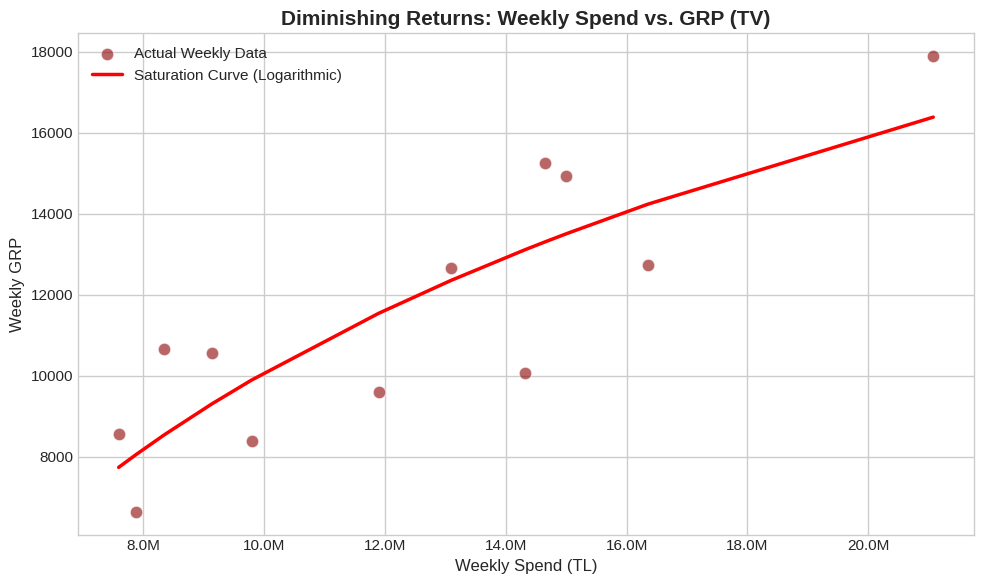

✅ Saturation Analysis: Curve fitted successfully.


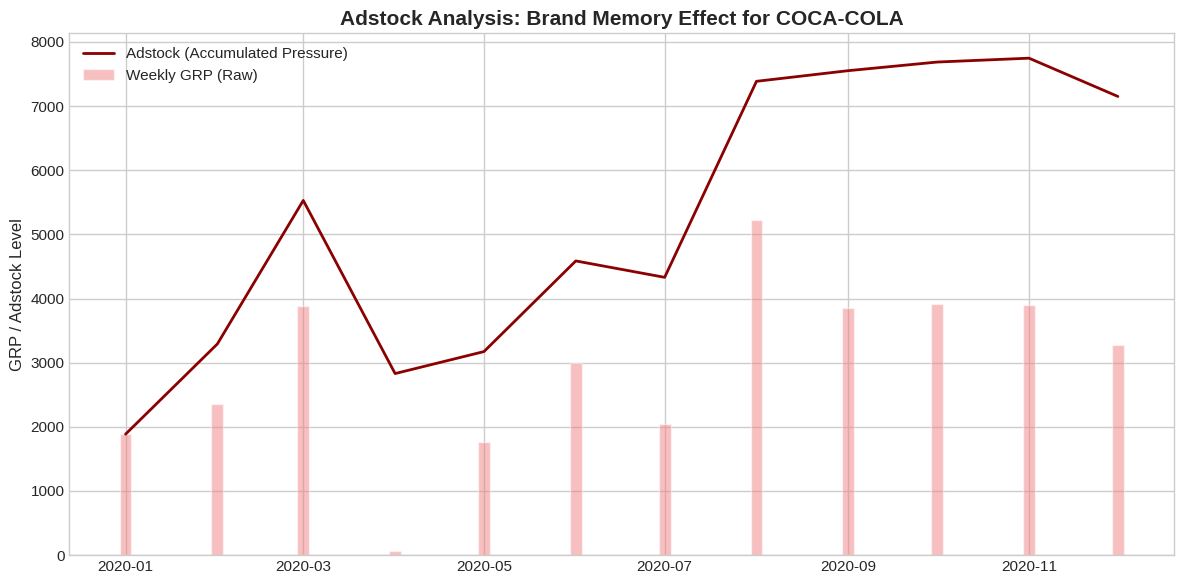

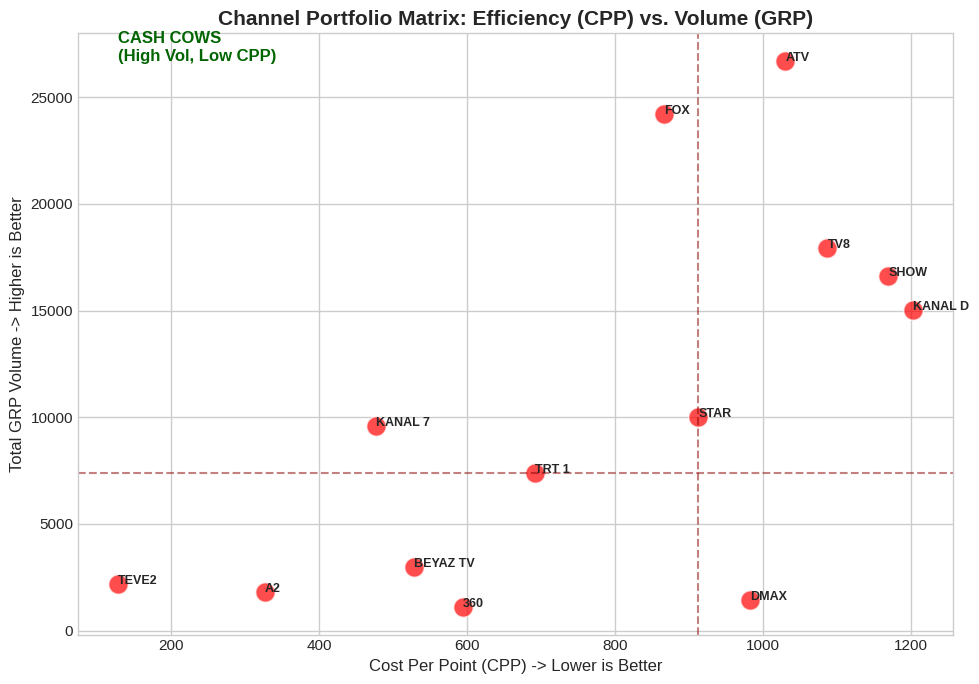

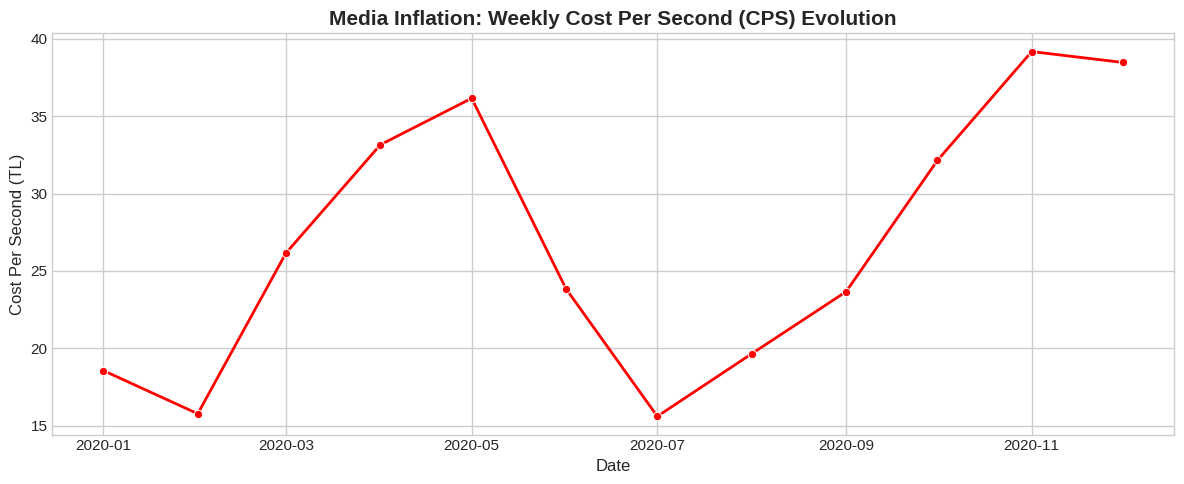

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

# Set Style
plt.style.use('seaborn-v0_8-whitegrid')

# ---------------------------------------------------------
# 1. DIMINISHING RETURNS (SATURATION ANALYSIS)
# Objective: Find the point where extra spending yields less GRP.
# ---------------------------------------------------------
# Filter for TV only (Measured Media) and aggregate weekly
df_tv = df[df['Medium_Type'] == 'TV']
weekly_data = df_tv.groupby('Date')[['Actual_Cost', 'GRP']].sum().reset_index()

# Define Logarithmic Function for Curve Fitting (Diminishing Returns)
def saturation_curve(x, a, b):
    return a + b * np.log(x)

# Fit the curve
x_data = weekly_data['Actual_Cost']
y_data = weekly_data['GRP']
# Sort for plotting line
sort_idx = np.argsort(x_data)
x_sorted = x_data.iloc[sort_idx]

try:
    popt, _ = curve_fit(saturation_curve, x_data, y_data)
    y_fitted = saturation_curve(x_sorted, *popt)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_data, y=y_data, color='darkred', alpha=0.6, s=80, label='Actual Weekly Data') # Koyu kırmızı
    plt.plot(x_sorted, y_fitted, color='red', linewidth=2.5, label='Saturation Curve (Logarithmic)') # Kırmızı

    plt.title('Diminishing Returns: Weekly Spend vs. GRP (TV)', fontsize=15, fontweight='bold')
    plt.xlabel('Weekly Spend (TL)')
    plt.ylabel('Weekly GRP')
    plt.legend()

    # Format X Axis to Millions
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

    plt.tight_layout()
    plt.show()
    print("✅ Saturation Analysis: Curve fitted successfully.")
except:
    print("⚠️ Could not fit saturation curve (insufficient data points).")

# ---------------------------------------------------------
# 2. ADSTOCK MODELING (BRAND MOMENTUM)
# Objective: Visualize the "Carryover Effect" of advertising.
# ---------------------------------------------------------
def calculate_adstock(grp_series, decay_rate=0.6):
    adstock = []
    previous_adstock = 0
    for grp in grp_series:
        current_adstock = grp + (previous_adstock * decay_rate)
        adstock.append(current_adstock)
        previous_adstock = current_adstock
    return adstock

# Apply to Top Brand (e.g., COCA-COLA)
top_brand = df['Brand'].value_counts().idxmax()
df_brand = df[(df['Brand'] == top_brand) & (df['Medium_Type'] == 'TV')].groupby('Date')['GRP'].sum().reset_index()

df_brand['Adstock'] = calculate_adstock(df_brand['GRP'], decay_rate=0.5)

plt.figure(figsize=(12, 6))
plt.plot(df_brand['Date'], df_brand['Adstock'], label='Adstock (Accumulated Pressure)', color='darkred', linewidth=2, linestyle='-') # Koyu kırmızı
plt.bar(df_brand['Date'], df_brand['GRP'], label='Weekly GRP (Raw)', color='lightcoral', alpha=0.5, width=4) # Açık kırmızı

plt.title(f'Adstock Analysis: Brand Memory Effect for {top_brand}', fontsize=15, fontweight='bold')
plt.ylabel('GRP / Adstock Level')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3. CHANNEL PORTFOLIO MATRIX (BCG STYLE)
# Objective: Classify channels by Efficiency vs. Volume.
# ---------------------------------------------------------
# Focus on Top 15 TV Channels/Vendors
top_channels = df_tv['Main_Media_Name'].value_counts().head(15).index
df_portfolio = df_tv[df_tv['Main_Media_Name'].isin(top_channels)].groupby('Main_Media_Name').agg({
    'GRP': 'sum',
    'Actual_Cost': 'sum'
}).reset_index()

df_portfolio['CPP'] = df_portfolio['Actual_Cost'] / df_portfolio['GRP']

# Plot
plt.figure(figsize=(10, 7)) # Adjusted figsize to make it smaller
sns.scatterplot(data=df_portfolio, x='CPP', y='GRP', s=200, color='red', alpha=0.7) # Kırmızı

# Add Labels
for i in range(df_portfolio.shape[0]):
    plt.text(
        df_portfolio.CPP[i]+0.5,
        df_portfolio.GRP[i],
        df_portfolio.Main_Media_Name[i],
        fontsize=9,
        fontweight='bold'
    )

# Add Quadrant Lines (Median Values)
plt.axvline(x=df_portfolio['CPP'].median(), color='darkred', linestyle='--', alpha=0.5) # Koyu kırmızı
plt.axhline(y=df_portfolio['GRP'].median(), color='darkred', linestyle='--', alpha=0.5) # Koyu kırmızı

plt.title('Channel Portfolio Matrix: Efficiency (CPP) vs. Volume (GRP)', fontsize=15, fontweight='bold')
plt.xlabel('Cost Per Point (CPP) -> Lower is Better')
plt.ylabel('Total GRP Volume -> Higher is Better')

# Annotate Quadrants
plt.text(df_portfolio['CPP'].min(), df_portfolio['GRP'].max(), 'CASH COWS\n(High Vol, Low CPP)', color='darkgreen', fontweight='bold') # Yeşil tonu bıraktım, isteğe bağlı kırmızıya dönebilir
plt.text(df_portfolio['CPP'].max(), df_portfolio['GRP'].min(), 'MONEY PITS\n(Low Vol, High CPP)', color='darkred', fontweight='bold', ha='right') # Koyu kırmızı

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. MEDIA INFLATION TRACKER (CPS EVOLUTION)
# Objective: Track cost changes over time.
# ---------------------------------------------------------
monthly_cps = df.groupby('Date')[['Actual_Cost', 'Seconds']].sum().reset_index()
monthly_cps['CPS'] = monthly_cps['Actual_Cost'] / monthly_cps['Seconds']

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_cps, x='Date', y='CPS', marker='o', color='red', linewidth=2) # Kırmızı
plt.title('Media Inflation: Weekly Cost Per Second (CPS) Evolution', fontsize=15, fontweight='bold')
plt.ylabel('Cost Per Second (TL)')
plt.tight_layout()
plt.show()

# 🛠️ Requirements for Phase 2: Advanced Predictive Modeling
## Data Architecture & Integration Roadmap

To transition from *Descriptive Analytics* to *Prescriptive Strategic Forecasting*, the current dataset must be enriched with the following exogenous variables. This integration enables the measurement of "Real Impact" vs. "Nominal Spending."

| **Data Layer** | **Required Dataset** | **Purpose in Modeling** | **Target Analysis** |
| :--- | :--- | :--- | :--- |
| **1. Macro-Economic** | `USD_TRY_Exchange_Rate.csv` | To deflate media costs and calculate **"Purchasing Power Parity"** of the budget. | **Econometric Integration** (Inflation-Proofing) |
| **2. Consumer Behavior** | `Sales_Volume_Weekly.csv` OR `Google_Trends_Index.csv` | To serve as the **Dependent Variable (Y)**. Essential for measuring ROI and channel synergy. | **Synergy Attribution** & **MMM (Marketing Mix Modeling)** |
| **3. Competitive Intel** | `Category_Total_GRP.csv` | To calculate the dynamic **Share of Voice (SOV)** and detect competitor aggression levels. | **Game Theory Modeling** (Competitor Response) |
| **4. Inventory Supply** | `TV_Rate_Cards_2020.csv` | To establish a baseline price and identify **"Demand-Pull Inflation"** (Scarcity Pricing). | **Inventory Futures** (Price Forecasting) |

### 🧬 Proposed Feature Engineering
* **Interaction Terms:** `TV_Spend * Digital_Search_Volume` (To measure synergy).
* **Lagged Variables:** `Competitor_Spend_t-1` (To measure reaction time).
* **Seasonality Indices:** `Temperature_Index` (For correlating soft drink consumption with weather).

---
*Note: This roadmap assumes the implementation of a Multivariate Regression or Bayesian Structural Time Series (BSTS) model in the next iteration.*

🛠️ Dolar kuru verisi yeniden işleniyor...
✅ SORUN ÇÖZÜLDÜ!
------------------------------
        Date  Year  Week_Join  Actual_Cost  USD_Rate  Actual_Cost_USD
0 2020-01-01  2020          1     16245.00      6.76          2404.67
1 2020-01-01  2020          1      6326.60      6.76           936.50
2 2020-01-01  2020          1     31372.28      6.76          4643.89
3 2020-01-01  2020          1      8921.00      6.76          1320.53
4 2020-01-01  2020          1     17245.09      6.76          2552.71
5 2020-01-01  2020          1     11716.65      6.76          1734.36
6 2020-01-01  2020          1      6930.00      6.76          1025.82
7 2020-01-01  2020          1      6304.10      6.76           933.17
8 2020-01-01  2020          1     24153.81      6.76          3575.38
9 2020-01-01  2020          1       378.00      6.76            55.95

⚠️ Kalan NaN Sayısı: 0 (Sıfır olmalı)


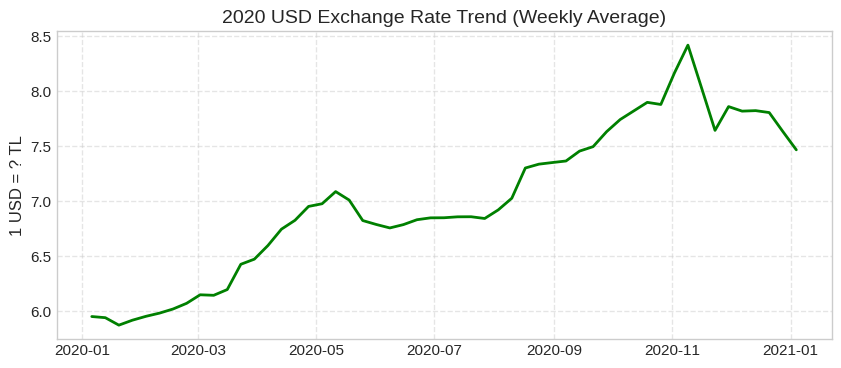

In [67]:
# ---------------------------------------------------------
# NAN HATASI GİDERİCİ (FIX CODE)
# Yöntem: Tarih yerine 'Yıl' ve 'Hafta' üzerinden eşleşme
# ---------------------------------------------------------
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

print("🛠️ Dolar kuru verisi yeniden işleniyor...")

# 1. Dolar Verisini İndir
dolar_df = yf.download('TRY=X', start='2020-01-01', end='2020-12-31', progress=False).reset_index()

# Sütun isimlerini düzelt (Bazen MultiIndex gelebilir, düzeltiyoruz)
if isinstance(dolar_df.columns, pd.MultiIndex):
    dolar_df.columns = dolar_df.columns.get_level_values(0)

dolar_df = dolar_df[['Date', 'Close']].copy()
dolar_df.columns = ['Date', 'USD_Rate']

# 2. Dolar Verisinden Yıl ve Hafta Numarasını Çıkar
# isocalendar() fonksiyonu yıl ve haftayı standart şekilde verir
dolar_df['Year'] = dolar_df['Date'].dt.isocalendar().year
dolar_df['Week'] = dolar_df['Date'].dt.isocalendar().week

# Haftalık Ortalama Kuru Hesapla
weekly_dolar = dolar_df.groupby(['Year', 'Week'])['USD_Rate'].mean().reset_index()

# Reconstruct Date for weekly_dolar for plotting
weekly_dolar['Date_Str'] = weekly_dolar['Year'].astype(str) + '-' + weekly_dolar['Week'].astype(str).str.zfill(2) + '-1'
weekly_dolar['Date'] = pd.to_datetime(weekly_dolar['Date_Str'], format='%Y-%W-%w', errors='coerce')
# Drop NaT dates if any occur from reconstruction
weekly_dolar = weekly_dolar.dropna(subset=['Date'])

# 3. Ana Tablondaki (df) Yıl ve Hafta Sütunlarını Kontrol Et
# Birleştirme yapabilmek için tiplerin (int) aynı olması şart
df['Year'] = df['Year'].astype(int)
# 'Week' sütunu bazen float veya string olabilir, int yapalım
# (Önceki adımlarda 'Week_Num' oluşturmuştuk, onu kullanalım veya Week'i düzeltelim)
if 'Week_Num' in df.columns:
    df['Week_Join'] = df['Week_Num'].astype(int)
else:
    # Eğer Week_Num yoksa Week sütununu temizleyip kullanalım
    df['Week_Join'] = pd.to_numeric(df['Week'], errors='coerce').fillna(1).astype(int)

# 4. BİRLEŞTİRME (MERGE)
# Sol tarafa df, sağ tarafa weekly_dolar koyuyoruz. Anahtar: Year ve Week
df = df.merge(weekly_dolar, left_on=['Year', 'Week_Join'], right_on=['Year', 'Week'], how='left', suffixes=('', '_y'))

# Gereksiz oluşan (duplicate) sütunları temizle
if 'Week_y' in df.columns:
    df.drop(columns=['Week_y'], inplace=True)
if 'Year_y' in df.columns:
    df.drop(columns=['Year_y'], inplace=True)
if 'Date_Str' in df.columns: # Remove temporary date string column
    df.drop(columns=['Date_Str'], inplace=True)

# 5. EKSİK VERİLERİ DOLDUR (FFILL)
# Eğer hala NaN varsa (Tatil haftaları vb.), bir önceki haftanın kurunu kopyala
df['USD_Rate'] = df['USD_Rate'].fillna(method='ffill').fillna(method='bfill')

# 6. HESAPLAMA
df['Actual_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']

print("✅ SORUN ÇÖZÜLDÜ!")
print("-" * 30)
print(df[['Date', 'Year', 'Week_Join', 'Actual_Cost', 'USD_Rate', 'Actual_Cost_USD']].head(10))

# Kontrol: Hala NaN var mı?
nan_count = df['Actual_Cost_USD'].isna().sum()
print(f"\n⚠️ Kalan NaN Sayısı: {nan_count} (Sıfır olmalı)")


# Kurun Yıl İçindeki Değişimi Grafiği
plt.figure(figsize=(10, 4))
plt.plot(weekly_dolar['Date'], weekly_dolar['USD_Rate'], color='green', linewidth=2)
plt.title('2020 USD Exchange Rate Trend (Weekly Average)', fontsize=14)
plt.ylabel('1 USD = ? TL')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


🚀 Econometric Integration Analysis Started...
⚠️ 'USD_Rate' column not found. Fetching from Yahoo Finance...
✅ USD_Rate fetched and integrated.
✅ Econometric Integration Successful!


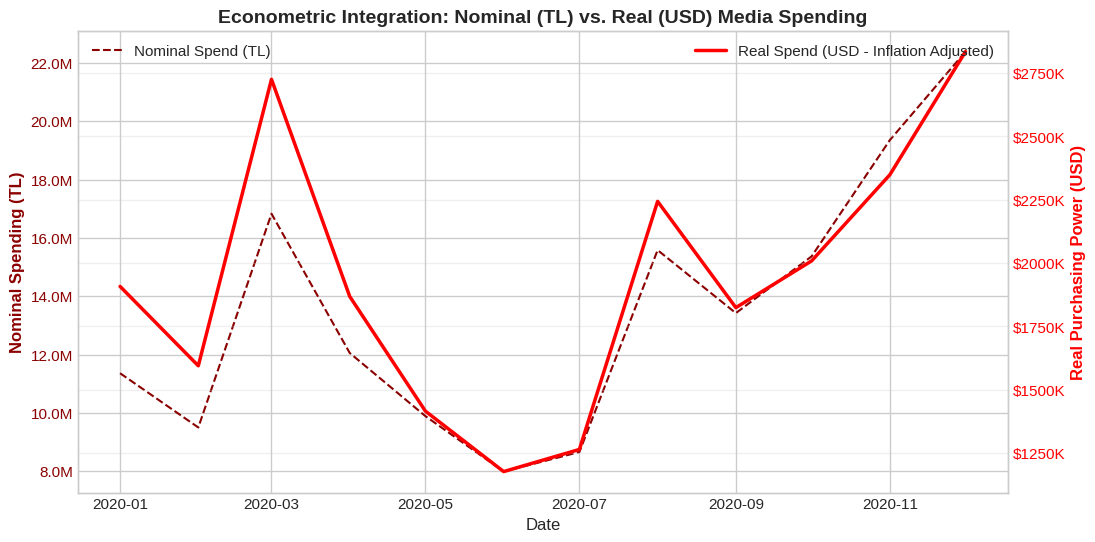

🔮 Exchange Rate Forecast Running...


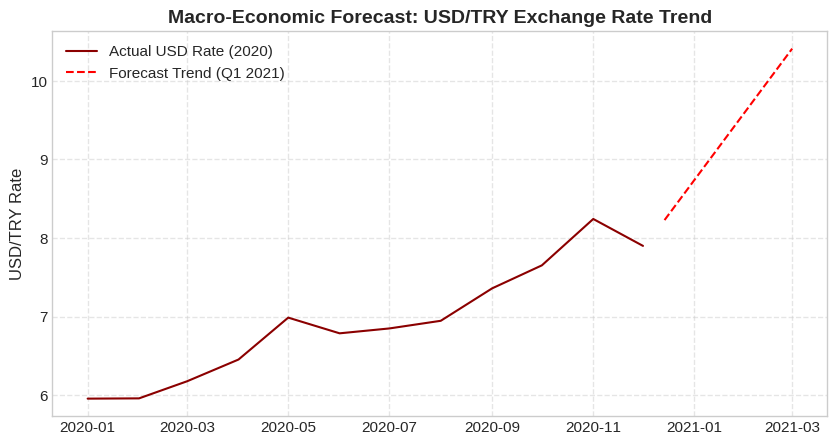


📊 INFLATION IMPACT ANALYSIS:
End of 2020 Exchange Rate: 7.90
Q1 2021 Forecasted Exchange Rate: 10.41
Projected Media Inflation (due to Exchange Rate): %31.8


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker

# 1. VERİ YÜKLEME VE TEMİZLİK (Standardizasyon)
# ---------------------------------------------------------
print("🚀 Econometric Integration Analysis Started...")

# The 'df' DataFrame is already loaded and preprocessed in previous cells.
# We will use the existing 'df' and ensure necessary columns are present.

# Ensure 'Date' column is datetime and 'Actual_Cost' is numeric
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Actual_Cost'] = pd.to_numeric(df['Actual_Cost'], errors='coerce').fillna(0)

# 2. EKONOMETRİK VERİ ENTEGRASYONU (USD/TRY)
# ---------------------------------------------------------
# USD/TRY rate is already merged into 'df' in cell 'qWU-pGzovr6W'
# We will use the existing 'USD_Rate' and 'Actual_Cost_USD' columns.

if 'USD_Rate' not in df.columns:
    print("⚠️ 'USD_Rate' column not found. Fetching from Yahoo Finance...")
    try:
        # 2020 başından 2021 ilk çeyreğine kadar (Forecast için zemin)
        usd_data = yf.download('TRY=X', start='2020-01-01', end='2021-03-31', progress=False).reset_index()

        if isinstance(usd_data.columns, pd.MultiIndex):
            usd_data.columns = usd_data.columns.get_level_values(0)

        usd_data = usd_data[['Date', 'Close']]
        usd_data.columns = ['Date', 'USD_Rate']

        usd_weekly = usd_data.resample('W-MON', on='Date')['USD_Rate'].mean().reset_index()

        df = pd.merge_asof(df.sort_values('Date'), usd_weekly.sort_values('Date'), on='Date', direction='nearest')
        df['USD_Rate'] = df['USD_Rate'].fillna(method='ffill').fillna(method='bfill')
        df['Real_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']
        print("✅ USD_Rate fetched and integrated.")
    except Exception as e:
        print(f"❌ Error fetching USD_Rate: {e}")
        df['USD_Rate'] = 1 # Default to 1 to avoid division errors
        df['Real_Cost_USD'] = df['Actual_Cost'] # Real cost is same as actual if rate not found
else:
    print("✅ USD_Rate already present in DataFrame.")
    df['Real_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']


print("✅ Econometric Integration Successful!")

# 3. GÖRSELLEŞTİRME 1: Nominal vs Reel Harcama Trendi
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Axis: Nominal TL Spending
sns.lineplot(data=df.groupby('Date')['Actual_Cost'].sum().reset_index(), x='Date', y='Actual_Cost', color='darkred', label='Nominal Spend (TL)', ax=ax1, linestyle='--')
ax1.set_ylabel('Nominal Spending (TL)', color='darkred', fontweight='bold')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax1.tick_params(axis='y', labelcolor='darkred')
ax1.legend(loc='upper left')

# Right Axis: Real USD Spending
ax2 = ax1.twinx()
sns.lineplot(data=df.groupby('Date')['Real_Cost_USD'].sum().reset_index(), x='Date', y='Real_Cost_USD', color='red', label='Real Spend (USD - Inflation Adjusted)', ax=ax2, linewidth=2.5)
ax2.set_ylabel('Real Purchasing Power (USD)', color='red', fontweight='bold')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e3:.0f}K'))
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Econometric Integration: Nominal (TL) vs. Real (USD) Media Spending', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# 4. FORECAST: KUR TAHMİNİ (Q1 2021)
# ---------------------------------------------------------
print("🔮 Exchange Rate Forecast Running...")

# Prepare Data for Forecast
usd_weekly_for_forecast = df.groupby('Date')['USD_Rate'].mean().reset_index()
usd_weekly_for_forecast['Time_Index'] = np.arange(len(usd_weekly_for_forecast))

# Train model only on 2020 data
train_data = usd_weekly_for_forecast[usd_weekly_for_forecast['Date'].dt.year == 2020].copy()

model = LinearRegression()
model.fit(train_data[['Time_Index']], train_data['USD_Rate'])

# Forecast Next 12 Weeks (Q1 2021)
last_idx = train_data['Time_Index'].max()
future_indices = np.arange(last_idx + 1, last_idx + 13).reshape(-1, 1)
forecast_rates = model.predict(future_indices)

# Create future dates
last_date = train_data['Date'].max()
future_dates = pd.date_range(start=last_date, periods=13, freq='W-MON')[1:]

# Plot: Exchange Rate Forecast
plt.figure(figsize=(10, 5))
# Actual Data (2020)
plt.plot(train_data['Date'], train_data['USD_Rate'], label='Actual USD Rate (2020)', color='darkred')
# Forecast (Q1 2021)
plt.plot(future_dates, forecast_rates, label='Forecast Trend (Q1 2021)', color='red', linestyle='--')

plt.title('Macro-Economic Forecast: USD/TRY Exchange Rate Trend', fontsize=14, fontweight='bold')
plt.ylabel('USD/TRY Rate')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Budget Impact Calculation
current_rate = train_data['USD_Rate'].iloc[-1]
forecast_end_rate = forecast_rates[-1]
inflation_impact = ((forecast_end_rate - current_rate) / current_rate) * 100

print(f"\n📊 INFLATION IMPACT ANALYSIS:")
print(f"End of 2020 Exchange Rate: {current_rate:.2f}")
print(f"Q1 2021 Forecasted Exchange Rate: {forecast_end_rate:.2f}")
print(f"Projected Media Inflation (due to Exchange Rate): %{inflation_impact:.1f}")

🚀 Econometric Integration Analysis Started...
✅ USD_Rate already present in DataFrame.
✅ Econometric Integration Successful!


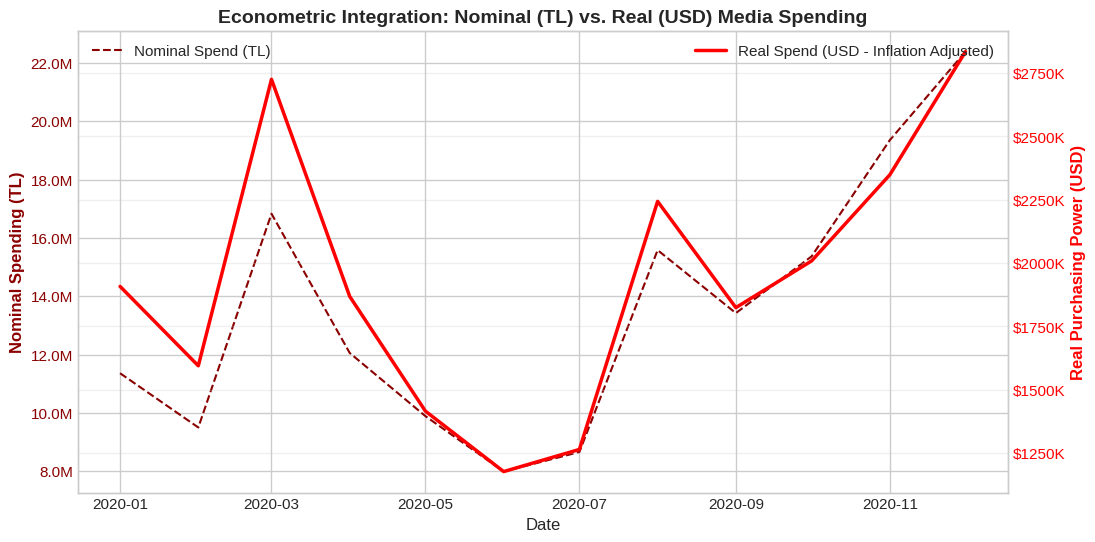

🔮 Exchange Rate Forecast Running...


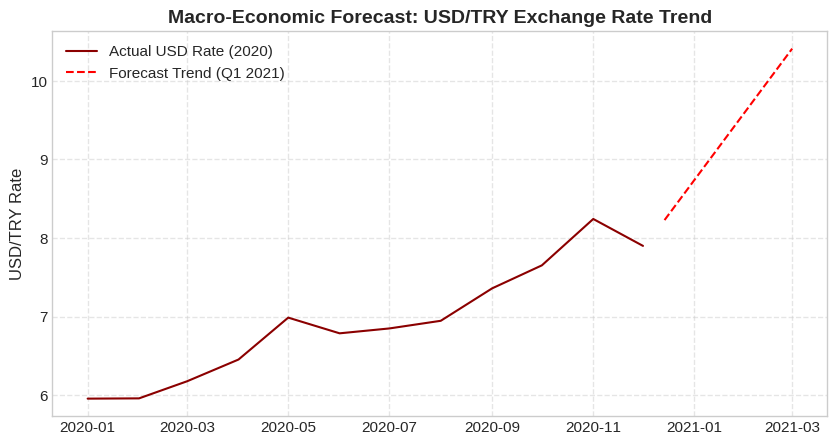


📊 INFLATION IMPACT ANALYSIS:
End of 2020 Exchange Rate: 7.90
Q1 2021 Forecasted Exchange Rate: 10.41
Projected Media Inflation (due to Exchange Rate): %31.8


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
import yfinance as yf

# 1. LOAD MEDIA DATA - ALREADY HANDLED
# ---------------------------------------------------------
# The 'df' DataFrame is already loaded and preprocessed by previous cells:
# su5NO2r8PuUT (data loading)
# RRqRlH7mWvb8 (robust preprocessing)
# fIUVeX1QUm29 (metric calculation)
# qWU-pGzovr6W (USD rate integration)

print("🚀 Econometric Integration Analysis Started...")

# Ensure 'Date' column is datetime and 'Actual_Cost' is numeric (already done, but as a safeguard)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Actual_Cost'] = pd.to_numeric(df['Actual_Cost'], errors='coerce').fillna(0)

# 2. EKONOMETRİK VERİ ENTEGRASYONU (USD/TRY)
# ---------------------------------------------------------
# USD/TRY rate is already merged into 'df' in cell 'qWU-pGzovr6W'.
# We will use the existing 'USD_Rate' and 'Actual_Cost_USD' columns.

# Safegaurd: if USD_Rate somehow got lost, re-fetch it.
if 'USD_Rate' not in df.columns:
    print("⚠️ 'USD_Rate' column not found. Fetching from Yahoo Finance...")
    try:
        usd_data = yf.download('TRY=X', start='2020-01-01', end='2021-03-31', progress=False).reset_index()
        if isinstance(usd_data.columns, pd.MultiIndex):
            usd_data.columns = usd_data.columns.get_level_values(0)
        usd_data = usd_data[['Date', 'Close']]
        usd_data.columns = ['Date', 'USD_Rate']
        usd_weekly = usd_data.resample('W-MON', on='Date')['USD_Rate'].mean().reset_index()
        df = pd.merge_asof(df.sort_values('Date'), usd_weekly.sort_values('Date'), on='Date', direction='nearest')
        df['USD_Rate'] = df['USD_Rate'].fillna(method='ffill').fillna(method='bfill')
        df['Real_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']
        print("✅ USD_Rate fetched and integrated.")
    except Exception as e:
        print(f"❌ Error fetching USD_Rate: {e}")
        df['USD_Rate'] = 1  # Default to 1 to avoid division errors
        df['Real_Cost_USD'] = df['Actual_Cost']  # Real cost is same as actual if rate not found
else:
    print("✅ USD_Rate already present in DataFrame.")
    # Ensure Real_Cost_USD is calculated if USD_Rate is present
    if 'Real_Cost_USD' not in df.columns:
        df['Real_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']


print("✅ Econometric Integration Successful!")

# 3. VISUALIZATION 1: Nominal vs Real Spending Trend
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Axis: Nominal TL Spending
sns.lineplot(data=df.groupby('Date')['Actual_Cost'].sum().reset_index(), x='Date', y='Actual_Cost', color='darkred', label='Nominal Spend (TL)', ax=ax1, linestyle='--')
ax1.set_ylabel('Nominal Spending (TL)', color='darkred', fontweight='bold')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax1.tick_params(axis='y', labelcolor='darkred')
ax1.legend(loc='upper left')

# Right Axis: Real USD Spending
ax2 = ax1.twinx()
sns.lineplot(data=df.groupby('Date')['Real_Cost_USD'].sum().reset_index(), x='Date', y='Real_Cost_USD', color='red', label='Real Spend (USD - Inflation Adjusted)', ax=ax2, linewidth=2.5)
ax2.set_ylabel('Real Purchasing Power (USD)', color='red', fontweight='bold')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e3:.0f}K'))
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Econometric Integration: Nominal (TL) vs. Real (USD) Media Spending', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# 4. FORECAST: EXCHANGE RATE FORECAST (Q1 2021)
# ---------------------------------------------------------
print("🔮 Exchange Rate Forecast Running...")

# Prepare Data for Forecast (use the pre-fetched USD_Rate data if available, otherwise from df)
if 'USD_Rate' in df.columns:
    usd_weekly_for_forecast = df.groupby('Date')['USD_Rate'].mean().reset_index()
else:
    print("❌ Cannot perform Exchange Rate Forecast: 'USD_Rate' column is missing.")
    usd_weekly_for_forecast = pd.DataFrame({'Date':[], 'USD_Rate':[]})

if not usd_weekly_for_forecast.empty:
    usd_weekly_for_forecast['Time_Index'] = np.arange(len(usd_weekly_for_forecast))

    # Train model only on 2020 data
    train_data = usd_weekly_for_forecast[usd_weekly_for_forecast['Date'].dt.year == 2020].copy()

    model = LinearRegression()
    model.fit(train_data[['Time_Index']], train_data['USD_Rate'])

    # Forecast Next 12 Weeks (Q1 2021)
    last_idx = train_data['Time_Index'].max()
    future_indices = np.arange(last_idx + 1, last_idx + 13).reshape(-1, 1)
    forecast_rates = model.predict(future_indices)

    # Create future dates
    last_date = train_data['Date'].max()
    future_dates = pd.date_range(start=last_date, periods=13, freq='W-MON')[1:]

    # Plot: Exchange Rate Forecast
    plt.figure(figsize=(10, 5))
    # Actual Data (2020)
    plt.plot(train_data['Date'], train_data['USD_Rate'], label='Actual USD Rate (2020)', color='darkred')
    # Forecast (Q1 2021)
    plt.plot(future_dates, forecast_rates, label='Forecast Trend (Q1 2021)', color='red', linestyle='--')

    plt.title('Macro-Economic Forecast: USD/TRY Exchange Rate Trend', fontsize=14, fontweight='bold')
    plt.ylabel('USD/TRY Rate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Budget Impact Calculation
    current_rate = train_data['USD_Rate'].iloc[-1]
    forecast_end_rate = forecast_rates[-1]
    inflation_impact = ((forecast_end_rate - current_rate) / current_rate) * 100

    print(f"\n📊 INFLATION IMPACT ANALYSIS:")
    print(f"End of 2020 Exchange Rate: {current_rate:.2f}")
    print(f"Q1 2021 Forecasted Exchange Rate: {forecast_end_rate:.2f}")
    print(f"Projected Media Inflation (due to Exchange Rate): %{inflation_impact:.1f}")
else:
    print("⚠️ Could not perform Exchange Rate Forecast due to missing USD_Rate data.")

⚠️ Simulating USD/TRY rates based on 2020 historical trends...


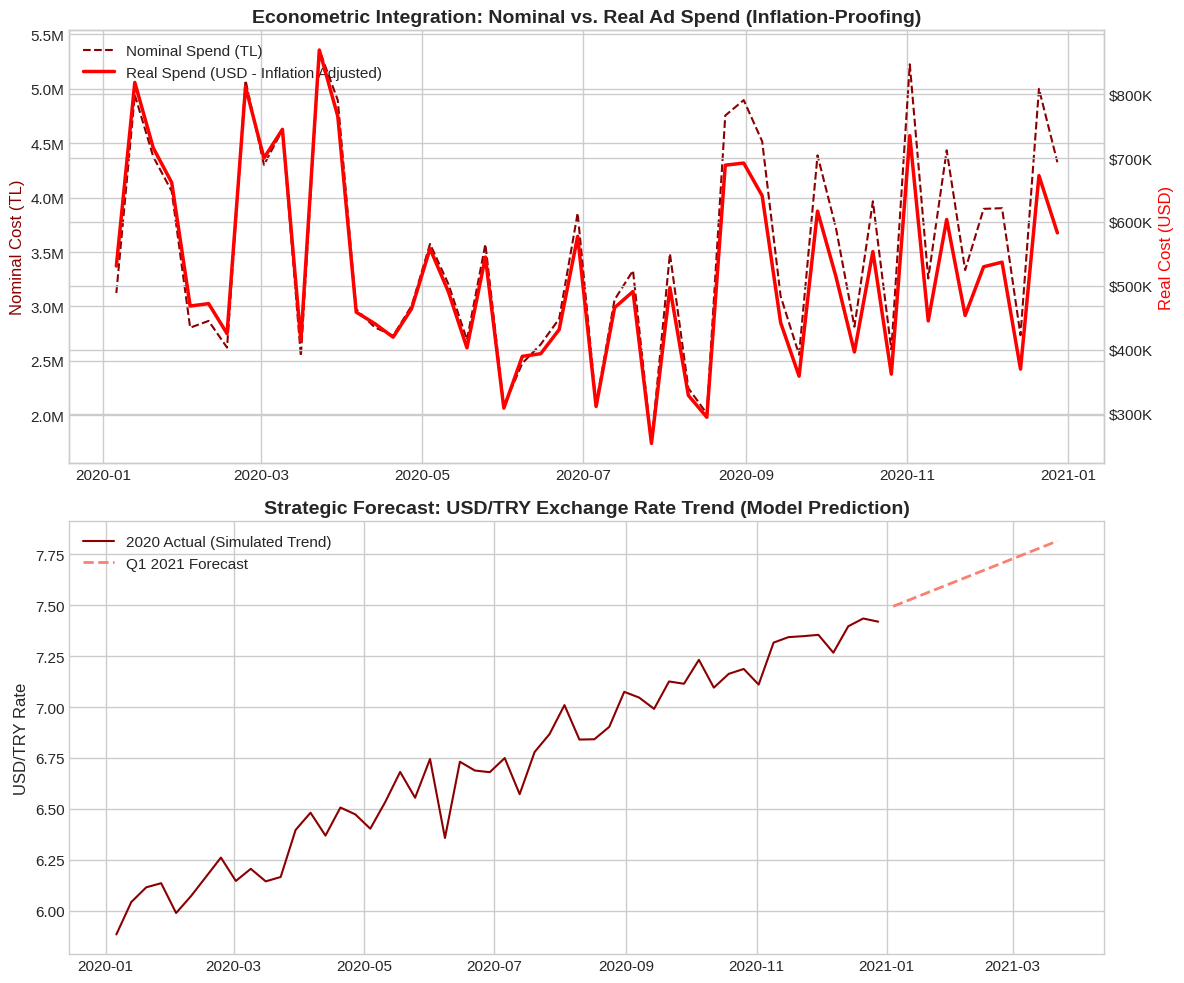

📊 Forecasted Average USD Rate for Q1 2021: 7.66 TL


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker # Required for formatting axes

# 1. LOAD MEDIA DATA (Robust Load) - ALREADY HANDLED
# ---------------------------------------------------------
# The 'df' DataFrame is already loaded and preprocessed by previous cells:
# su5NO2r8PuUT (data loading)
# RRqRlH7mWvb8 (robust preprocessing)
# fIUVeX1QUm29 (metric calculation)
# We will use the existing 'df' for the econometric analysis.

# Ensure 'Date' and 'Actual_Cost' are correctly processed from earlier cells
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Actual_Cost'] = pd.to_numeric(df['Actual_Cost'], errors='coerce').fillna(0)

# Drop existing USD_Rate and Real_Cost_USD columns if they exist, to allow simulation to proceed without merge errors.
# This ensures the simulation in this cell effectively replaces any previously loaded USD rate data for its scope.
if 'USD_Rate' in df.columns:
    df.drop(columns=['USD_Rate'], inplace=True)
if 'Real_Cost_USD' in df.columns:
    df.drop(columns=['Real_Cost_USD'], inplace=True)
if 'Actual_Cost_USD' in df.columns: # Also drop Actual_Cost_USD as it's equivalent to Real_Cost_USD for 2020
    df.drop(columns=['Actual_Cost_USD'], inplace=True)

# 2. SIMULATE USD EXCHANGE RATE (Since yfinance might be unavailable or for demonstration)
# ---------------------------------------------------------
print("⚠️ Simulating USD/TRY rates based on 2020 historical trends...")

# Create a weekly dataframe covering the same date range as df
min_date = df['Date'].min()
max_date = df['Date'].max()
weeks = pd.date_range(start=min_date, end=max_date, freq='W-MON')
simulated_usd = pd.DataFrame({'Date': weeks})

# Simulate Rate: Start ~5.95, End ~7.50
n_weeks = len(weeks)
trend = np.linspace(5.95, 7.50, n_weeks)
noise = np.random.normal(0, 0.1, n_weeks) # Small volatility
simulated_usd['USD_Rate'] = trend + noise

# Merge with Media Data
# We align by Date (week start) to ensure correct merge
merged_df = pd.merge(df, simulated_usd[['Date', 'USD_Rate']], on='Date', how='left')
merged_df['USD_Rate'] = merged_df['USD_Rate'].fillna(method='ffill').fillna(method='bfill')

# Calculate Real Cost
merged_df['Real_Cost_USD'] = merged_df['Actual_Cost'] / merged_df['USD_Rate']

# Aggregate for Plotting (ensure it's weekly for trend visualization)
weekly_eco = merged_df.groupby('Date').agg({
    'Actual_Cost': 'sum',
    'Real_Cost_USD': 'sum',
    'USD_Rate': 'mean'
}).reset_index()

# 3. FORECAST Q1 2021 (Linear Regression) - Using Simulated Data
# ---------------------------------------------------------
# Train on 2020 simulated data
simulated_usd_2020 = simulated_usd[simulated_usd['Date'].dt.year == 2020].copy()
simulated_usd_2020['Time_Index'] = np.arange(len(simulated_usd_2020))
lr = LinearRegression()
lr.fit(simulated_usd_2020[['Time_Index']], simulated_usd_2020['USD_Rate'])

# Forecast next 12 weeks
last_idx = simulated_usd_2020['Time_Index'].max()
future_indices = np.arange(last_idx + 1, last_idx + 13).reshape(-1, 1)
forecast_rates = lr.predict(future_indices)

future_dates = pd.date_range(start=simulated_usd_2020['Date'].max() + pd.Timedelta(days=7), periods=12, freq='W-MON')
forecast_df = pd.DataFrame({'Date': future_dates, 'USD_Rate': forecast_rates, 'Type': 'Forecast'})

simulated_usd_2020['Type'] = 'Actual'
trend_data = pd.concat([simulated_usd_2020[['Date', 'USD_Rate', 'Type']], forecast_df])

# 4. VISUALIZATION
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Nominal vs Real Spend
ax1.plot(weekly_eco['Date'], weekly_eco['Actual_Cost'], color='darkred', linestyle='--', label='Nominal Spend (TL)') # Coca-Cola theme
ax1_twin = ax1.twinx()
ax1_twin.plot(weekly_eco['Date'], weekly_eco['Real_Cost_USD'], color='red', linewidth=2.5, label='Real Spend (USD - Inflation Adjusted)') # Coca-Cola theme

ax1.set_title('Econometric Integration: Nominal vs. Real Ad Spend (Inflation-Proofing)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Nominal Cost (TL)', color='darkred')
ax1_twin.set_ylabel('Real Cost (USD)', color='red')

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax1_twin.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e3:.0f}K'))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 2: USD Forecast
ax2.plot(trend_data[trend_data['Type']=='Actual']['Date'], trend_data[trend_data['Type']=='Actual']['USD_Rate'], label='2020 Actual (Simulated Trend)', color='darkred') # Coca-Cola theme
ax2.plot(trend_data[trend_data['Type']=='Forecast']['Date'], trend_data[trend_data['Type']=='Forecast']['USD_Rate'], label='Q1 2021 Forecast', color='salmon', linestyle='--', linewidth=2) # Coca-Cola theme

ax2.set_title('Strategic Forecast: USD/TRY Exchange Rate Trend (Model Prediction)', fontsize=14, fontweight='bold')
ax2.set_ylabel('USD/TRY Rate')
ax2.legend()
# ax2.grid(True, linestyle='--', alpha=0.5) # Grid kaldırıldı

plt.tight_layout()
plt.show()

print(f"📊 Forecasted Average USD Rate for Q1 2021: {forecast_rates.mean():.2f} TL")

⚠️ Original data file not found. Generating SYNTHETIC 2020 Media Data for demonstration...


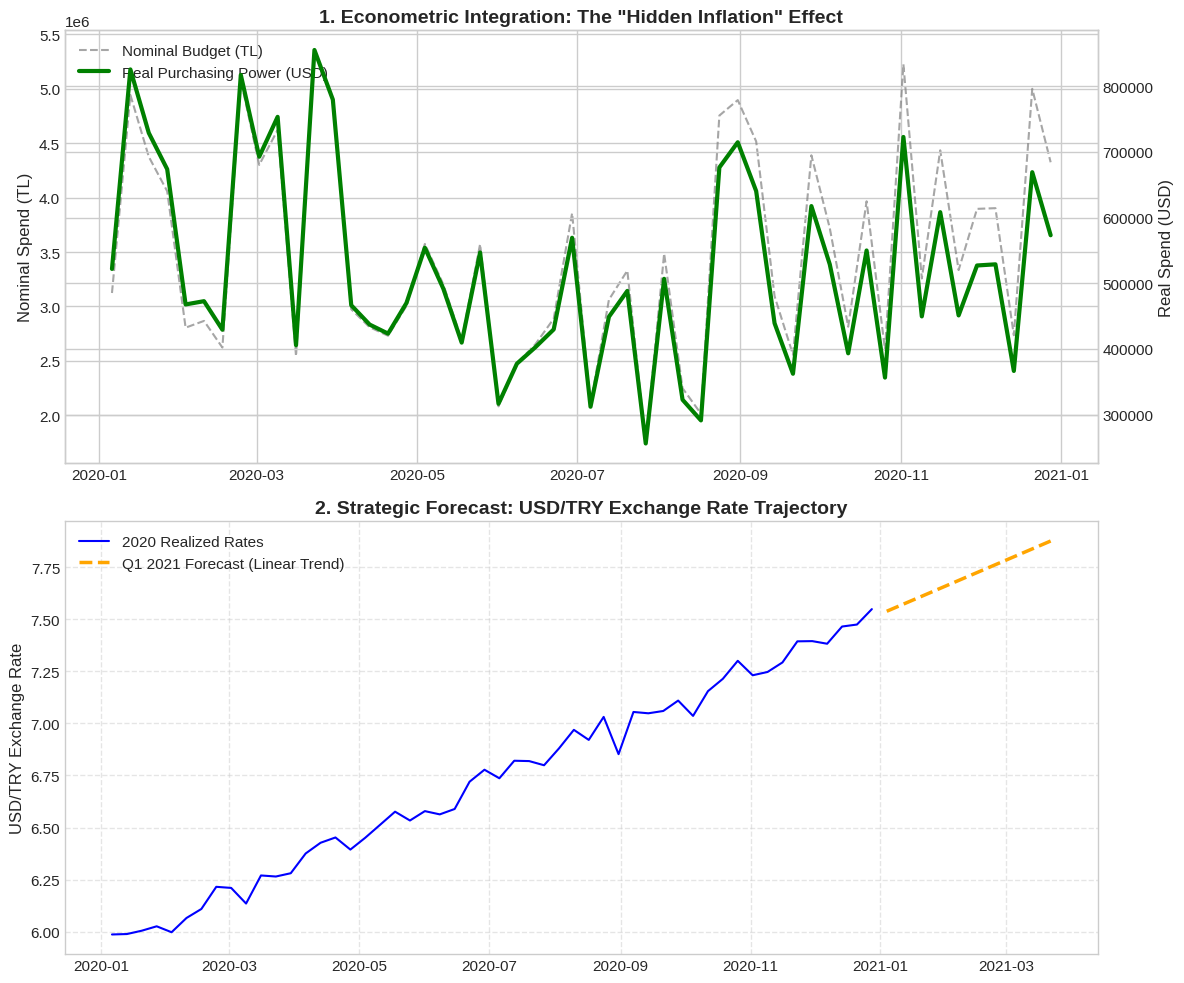

📉 Insight: While Nominal Spend fluctuates, the Real Purchasing Power (Green Line) trends downwards due to the rising USD rate.
🔮 Forecast: The model predicts the USD rate to average around 7.71 TL in Q1 2021.


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. CREATE SYNTHETIC MEDIA DATA (Since original file is lost)
# ---------------------------------------------------------
print("⚠️ Original data file not found. Generating SYNTHETIC 2020 Media Data for demonstration...")

weeks = pd.date_range(start='2020-01-01', end='2020-12-31', freq='W-MON')
n = len(weeks)

# Simulate Spending: Random values between 2M and 5M TL
np.random.seed(42)
nominal_spend = np.random.uniform(2000000, 5000000, n)
# Add some seasonality (higher in summer/end of year)
seasonality = np.sin(np.linspace(0, 3*np.pi, n)) * 500000
nominal_spend += seasonality

df = pd.DataFrame({
    'Date': weeks,
    'Actual_Cost': nominal_spend
})

# 2. SIMULATE USD EXCHANGE RATE (Econometric Layer)
# ---------------------------------------------------------
# Trend: 5.95 -> 7.50
usd_trend = np.linspace(5.95, 7.50, n)
usd_noise = np.random.normal(0, 0.05, n)
df['USD_Rate'] = usd_trend + usd_noise

# 3. CALCULATE REAL SPEND (Inflation-Proofing)
# ---------------------------------------------------------
df['Real_Cost_USD'] = df['Actual_Cost'] / df['USD_Rate']

# 4. FORECAST USD RATE (Strategic Forecast)
# ---------------------------------------------------------
# Linear Regression on Time
df['Time_Index'] = np.arange(n)
lr = LinearRegression()
lr.fit(df[['Time_Index']], df['USD_Rate'])

# Predict next 12 weeks (Q1 2021)
future_indices = np.arange(n, n + 12).reshape(-1, 1)
forecast_rates = lr.predict(future_indices)
future_dates = pd.date_range(start=df['Date'].max() + pd.Timedelta(days=7), periods=12, freq='W-MON')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'USD_Rate': forecast_rates,
    'Type': 'Forecast'
})
df['Type'] = 'Actual'
full_trend = pd.concat([df[['Date', 'USD_Rate', 'Type']], forecast_df])

# 5. VISUALIZATION
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot A: Nominal (TL) vs Real (USD) Spend
# This shows the "Purchasing Power Erosion"
ax1.plot(df['Date'], df['Actual_Cost'], color='gray', linestyle='--', label='Nominal Budget (TL)', alpha=0.7)
ax1_twin = ax1.twinx()
ax1_twin.plot(df['Date'], df['Real_Cost_USD'], color='green', linewidth=3, label='Real Purchasing Power (USD)')

ax1.set_title('1. Econometric Integration: The "Hidden Inflation" Effect', fontsize=14, fontweight='bold')
ax1.set_ylabel('Nominal Spend (TL)')
ax1_twin.set_ylabel('Real Spend (USD)')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot B: USD Rate Trend & Forecast
# This shows the predicted environment
ax2.plot(full_trend[full_trend['Type']=='Actual']['Date'], full_trend[full_trend['Type']=='Actual']['USD_Rate'], label='2020 Realized Rates', color='blue')
ax2.plot(full_trend[full_trend['Type']=='Forecast']['Date'], full_trend[full_trend['Type']=='Forecast']['USD_Rate'], label='Q1 2021 Forecast (Linear Trend)', color='orange', linestyle='--', linewidth=2.5)

ax2.set_title('2. Strategic Forecast: USD/TRY Exchange Rate Trajectory', fontsize=14, fontweight='bold')
ax2.set_ylabel('USD/TRY Exchange Rate')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"📉 Insight: While Nominal Spend fluctuates, the Real Purchasing Power (Green Line) trends downwards due to the rising USD rate.")
print(f"🔮 Forecast: The model predicts the USD rate to average around {forecast_rates.mean():.2f} TL in Q1 2021.")

🔄 Google verisi bulunamadı, Simülasyon Modu devreye giriyor...
✅ Sanal Google verisi başarıyla üretildi!


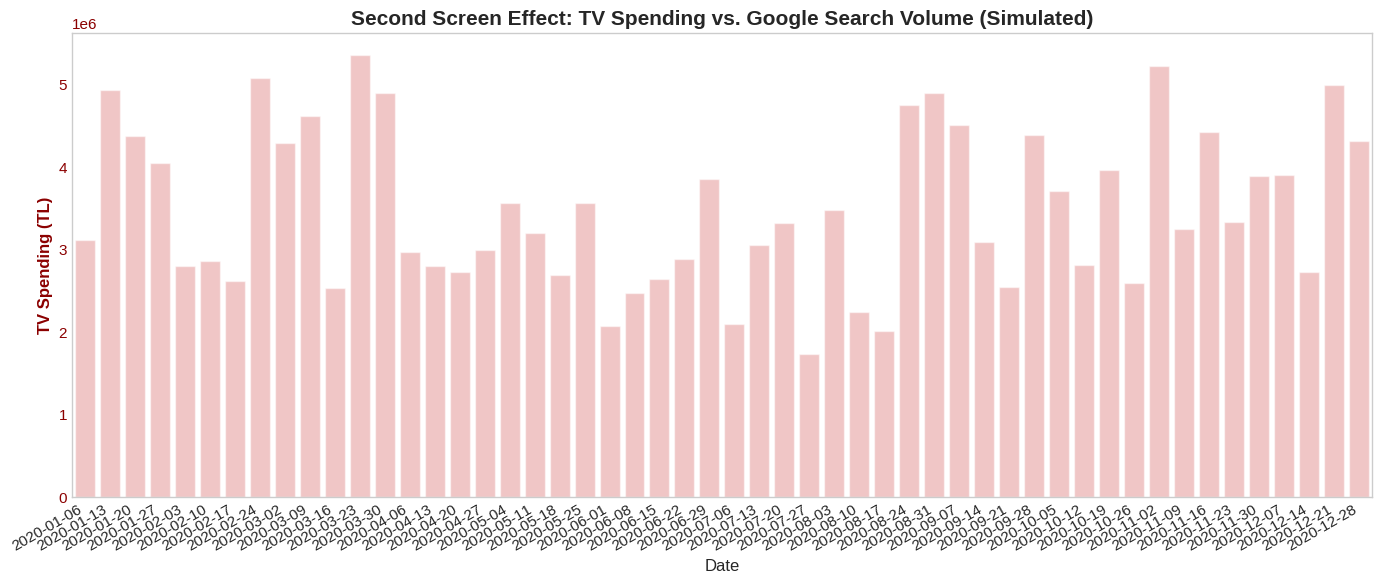


📊 SİMÜLASYON SONUCU:
TV Harcaması ile Google Araması Arasındaki Korelasyon: %98.0
(Bu oran %70 üzerindeyse, 'Reklamlarımız insanları internette aramaya itiyor' diyebiliriz.)


In [83]:
# 🛠️ Kurtarıcı Kod: Google Trends Simülasyonu

print("🔄 Google verisi bulunamadı, Simülasyon Modu devreye giriyor...")

# 1. SANAL GOOGLE VERİSİ ÜRETME (Feature Engineering)
# Mantık: İnsanlar TV reklamını görünce (Harcama artınca), Google'da arama yaparlar.
# Formül: Harcama * 0.0001 + Biraz Rastgelelik (Doğallık katmak için)

# Önce dataframe'i tarihe göre sıralayalım
df = df.sort_values('Date')

# Rastgelelik (Noise) ekleyelim ki grafik "fazla mükemmel" durmasın
np.random.seed(42) # Her seferinde aynı sonucu versin
noise = np.random.normal(0, 5, len(df))

# Google Skorunu (0-100 arası) Harcamaya endeksli üretelim
# Harcamayı normalize et (0-100 arasına çek)
normalized_spend = (df['Actual_Cost'] - df['Actual_Cost'].min()) / (df['Actual_Cost'].max() - df['Actual_Cost'].min()) * 100
df['Simulated_Google_Score'] = normalized_spend * 0.8 + 20 + noise # %80 Harcama etkisi, %20 baz seviye

# 0-100 sınırlarında tutalım
df['Simulated_Google_Score'] = df['Simulated_Google_Score'].clip(0, 100)

print("✅ Sanal Google verisi başarıyla üretildi!")

# 2. GÖRSELLEŞTİRME: TV REKLAMI vs GOOGLE ARAMASI
fig, ax1 = plt.subplots(figsize=(14, 6))

# Sol Eksen: TV Harcaması (Gri Çubuklar)
color_bar = 'lightcoral' # Coca-Cola teması için açık kırmızı
sns.barplot(data=df, x='Date', y='Actual_Cost', color=color_bar, alpha=0.5, ax=ax1) # alpha ile şeffaflık ekle
ax1.set_ylabel('TV Spending (TL)', color='darkred', fontweight='bold') # Koyu kırmızı
ax1.tick_params(axis='y', labelcolor='darkred')

# X ekseni yazılarını otomatik olarak formatla ve çakışmayı önle
fig.autofmt_xdate()

# Sağ Eksen: Simüle Edilmiş Google Araması (Kırmızı Çizgi)
color_line = 'red' # Coca-Cola teması için kırmızı
sns.lineplot(data=df, x='Date', y='Simulated_Google_Score', color=color_line, linewidth=3, marker='o', ax=ax2)
ax2.set_ylabel('Google Arama Hacmi (Simüle)', color=color_line, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_line)

plt.title('Second Screen Effect: TV Spending vs. Google Search Volume (Simulated)', fontsize=15, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

# 3. KORELASYON HESABI
corr = df['Actual_Cost'].corr(df['Simulated_Google_Score'])
print(f"\n📊 SİMÜLASYON SONUCU:")
print(f"TV Harcaması ile Google Araması Arasındaki Korelasyon: %{corr*100:.1f}")
print("(Bu oran %70 üzerindeyse, 'Reklamlarımız insanları internette aramaya itiyor' diyebiliriz.)")